# Compare ref run (peat_30min_ext) with TCZERO bug correction + snd forcing (instead of Snowf) 

http://localhost:8888/lab/tree/CLASSIC/in_situ/SnowArctic/byl/forcing/SnowMIP_to_CLASSIC_forcing_30min_ext_snd.ipynb

In [2]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import calendar
import os

In [3]:
site = 'byl'
site_longname = 'Bylot Island, Canadian high Arctic'
y_start = 2013
y_end = 2019

# labels = ['peat_30min_ext', 'peat']
labels = ['peat_30min_ext', 'peat_TCZERO_30min_ext', 'peat_TCZERO_30min_ext_snd']

root_path = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/'+site+'/'
paths = [root_path+'run_'+label for label in labels]

# ds_yr_list = [xr.open_mfdataset(path+'/*_annually.nc').squeeze().load() for path in paths]
# ds_mo_list = [xr.open_mfdataset(path+'/*_monthly.nc').squeeze().load() for path in paths]
ds_d_list = [xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths]
# ds_hh_list = [xr.open_mfdataset(path+'/*_halfhourly.nc').squeeze().load() for path in paths]

In [4]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/"+site
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_Ref.nc')

In [5]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [6]:
for i in range(len(labels)):
    # ds_yr_list[i] = assign_center_depth(ds_yr_list[i], rsfile)
    # ds_mo_list[i] = assign_center_depth(ds_mo_list[i], rsfile)
    ds_d_list[i] = assign_center_depth(ds_d_list[i], rsfile)
    # ds_hh_list[i] = assign_center_depth(ds_hh_list[i], rsfile)

Text(0.5, 0.98, 'Bylot Island, Canadian high Arctic')

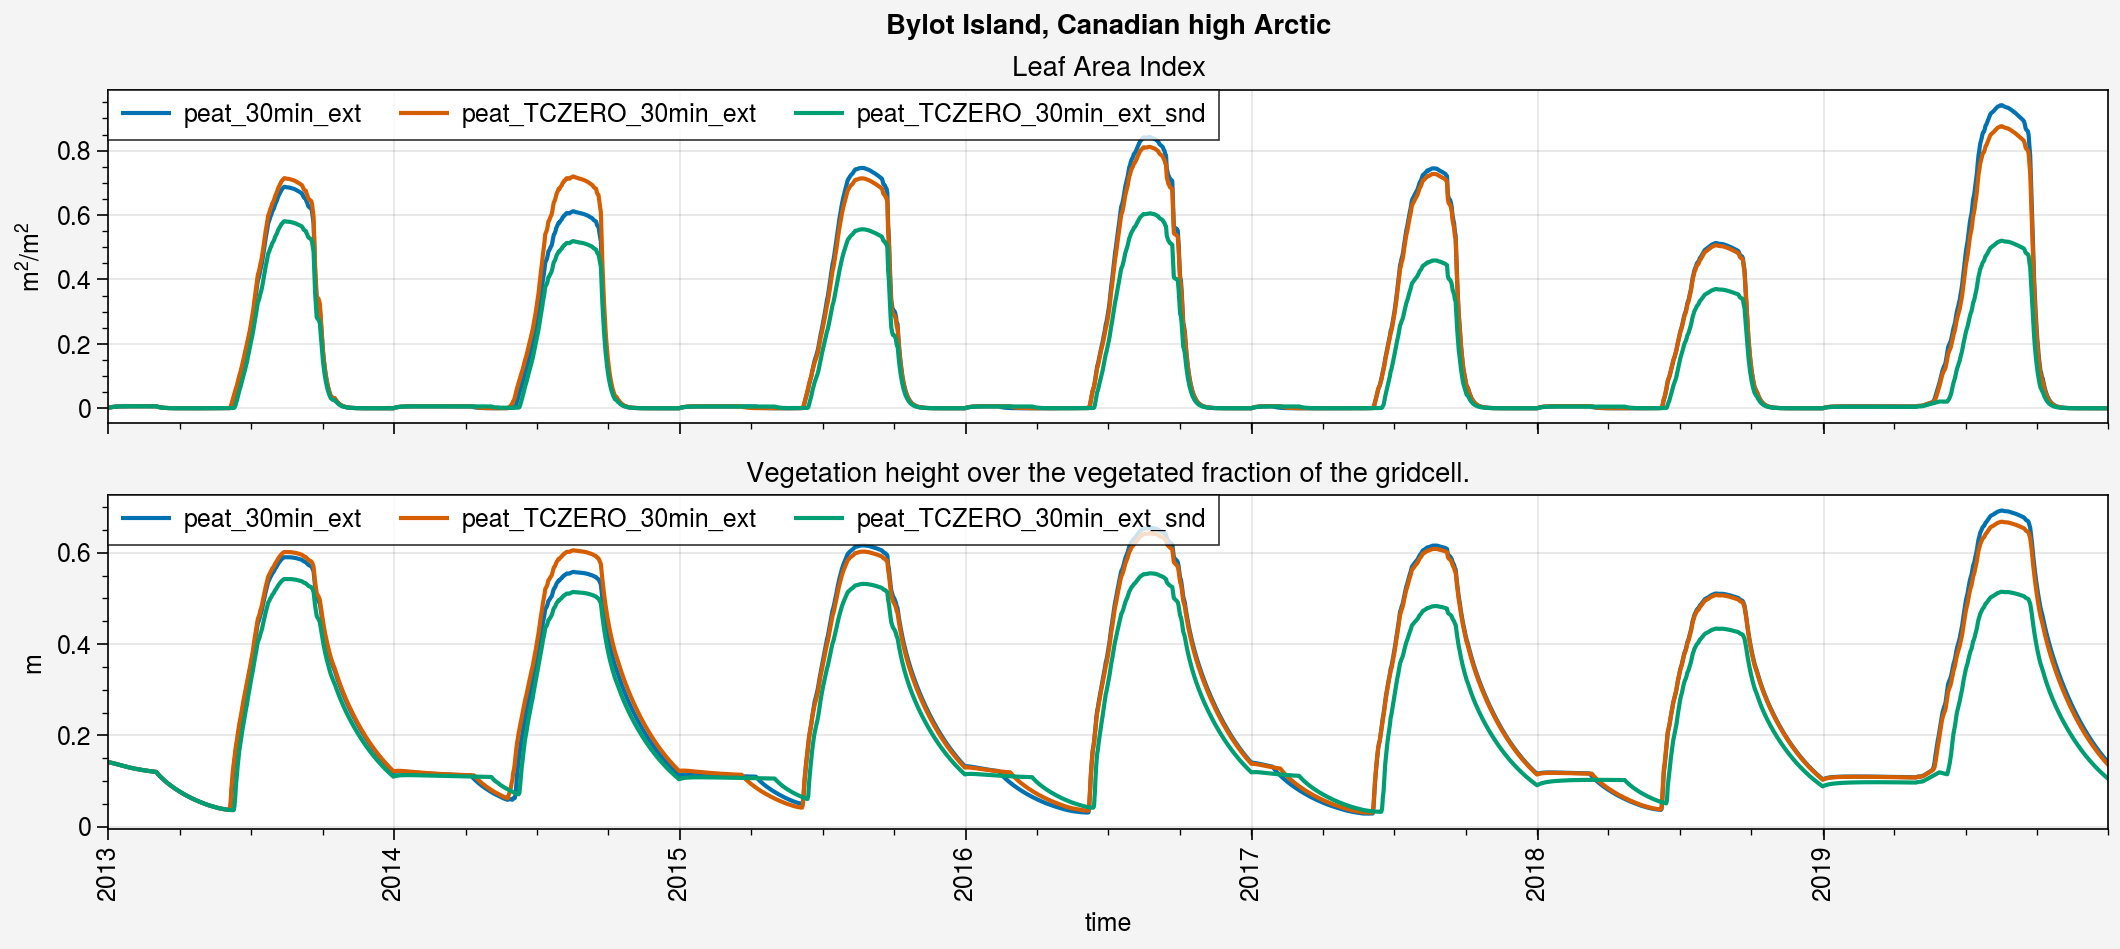

In [7]:
fig, axs = pplt.subplots(ncols=1, nrows=2, refaspect=6, refwidth=10, sharey=0)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.lai, label=label)
    axs[1].plot(ds_d.vegHeight, label=label)

axs[0].format(ylabel=ds_d_list[0].lai.units, title=ds_d_list[0].lai.long_name)
axs[1].format(ylabel=ds_d_list[0].vegHeight.units, title=ds_d_list[0].vegHeight.long_name)

for ax in axs:
    ax.legend()

fig.suptitle(site_longname)

Text(0.5, 0.98, 'Bylot Island, Canadian high Arctic (2013-2019)')

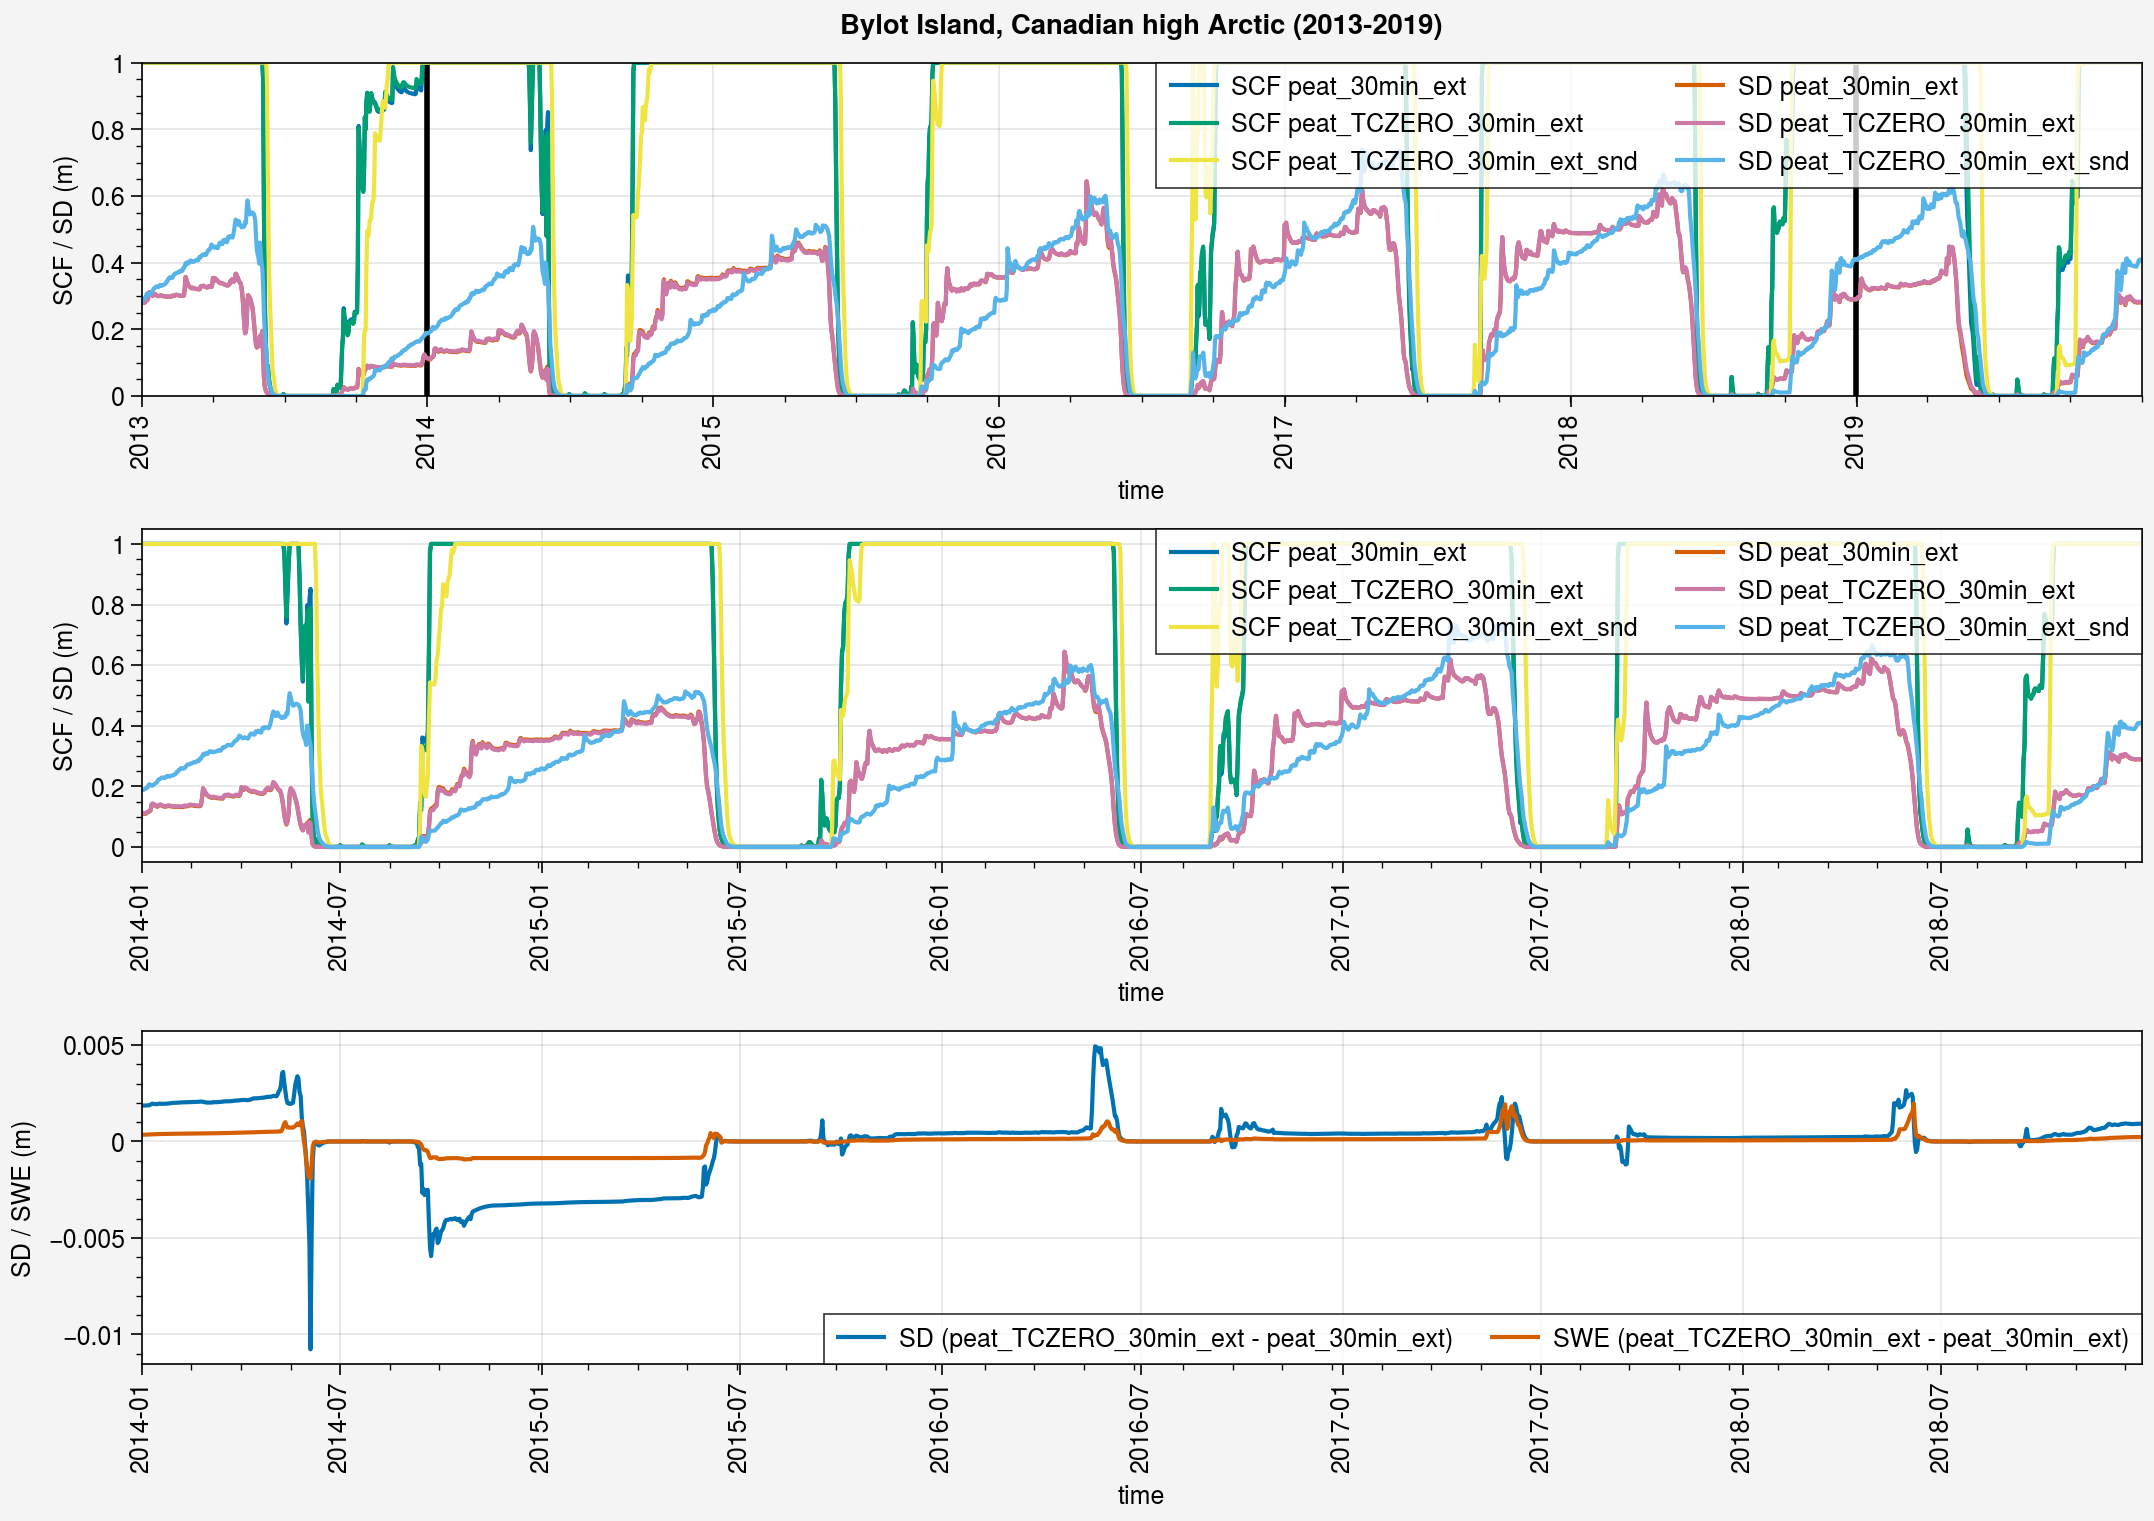

In [8]:
if len(labels) > 1:
    nrows = 3
else: 
    nrows = 2
    
fig, axs = pplt.subplots(ncols=1, nrows=nrows, refaspect=6, refwidth=10, share=0)

##################
### All period ###
##################
start = str(y_start)
end = str(y_end)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[0].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].legend(ncols=2, loc='ur')
axs[0].format(
    ylabel='SCF / SD (m)'
)


############
### Zoom ###
############
start = str(y_start+1)
end = str(y_end-1)

for ds_d, label in zip(ds_d_list, labels):
    axs[1].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[1].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[0], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)
axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[-1], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)

axs[1].legend(ncols=2, loc='ur')
axs[1].format(
    ylabel='SCF / SD (m)'
)

if nrows == 3:
    #####################
    ### SWE / SD diff ###
    #####################
    axs[2].plot((ds_d_list[1]-ds_d_list[0]).snd.sel(time=slice(start,end)), label='SD ('+labels[1]+' - '+labels[0]+')')
    axs[2].plot(((ds_d_list[1]-ds_d_list[0]).snw*1e-3).sel(time=slice(start,end)), label='SWE ('+labels[1]+' - '+labels[0]+')')
    
    axs[2].legend(ncols=2)
    axs[2].format(
        ylabel='SD / SWE (m)'
    )

fig.suptitle(site_longname+' ('+str(y_start)+'-'+str(y_end)+')')


## Compare with obs

In [9]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'

ds_h_obs = xr.open_dataset(path_obs+'/obs_insitu_'+site+'_'+str(y_start)+'_'+str(y_end)+'.nc').load()
ds_h_obs['albs'] = ds_h_obs.albs.where(ds_h_obs.flag_albs_ERA5 == 0).where(ds_h_obs.albs < 1) # to avoid > 1 albedo values
ds_d_obs = ds_h_obs.resample(time='D').mean().load()
ds_h_met = xr.open_dataset(path_obs+'/met_insitu_'+site+'_'+str(y_start)+'_'+str(y_end)+'.nc').load()

ds_h_obs

<xarray.Dataset> Size: 10MB
Dimensions:         (time: 52202, sdepth: 5, sheight: 10)
Coordinates:
  * time            (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-...
  * sdepth          (sdepth) float64 40B 0.02 0.05 0.1 0.15 0.21
  * sheight         (sheight) float64 80B 0.0 0.02 0.05 0.07 ... 0.27 0.35 0.37
Data variables:
    snd_auto        (time) float64 418kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    albs            (time) float64 418kB 0.16 0.15 0.17 0.16 ... 0.17 0.16 0.16
    flag_albs_ERA5  (time) int64 418kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ts              (time) float64 418kB 9.86 10.42 13.45 ... 10.71 14.89 nan
    mrsll           (sdepth, time) float64 2MB 0.2 0.2 0.2 ... 0.066 0.066 0.066
    tsl             (sdepth, time) float64 2MB 3.7 4.3 4.99 ... -0.3 -0.3 -0.3
    tsnl            (sheight, time) float64 4MB nan nan nan nan ... nan nan nan
Attributes:
    reference:    Domine, F., Lackner, G., Sarrazin, D., Poirier, M., & Belke...
    description:  Converted to netCDF (SnowMIP kind of format) from original ...

### SD

In [12]:
path_SALIX = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot/timelapse/SALIX_F'
df_SALIX = pd.read_excel(path_SALIX+'/SnowDepth_SALIX_F.xlsx', skiprows=1, date_format='time_stamp', index_col='time_stamp')
df_SALIX.index.names = ['time']
df_SALIX

TUNDRA  SALIX-F
time                                
2016-07-09 14:00:00     0.0      0.0
2016-07-09 15:00:00     0.0      0.0
2016-07-09 16:00:00     0.0      0.0
2016-07-09 17:00:00     0.0      0.0
2016-07-09 18:00:00     0.0      0.0
...                     ...      ...
2019-07-05 10:00:00     0.0      0.0
2019-07-05 11:00:00     0.0      0.0
2019-07-05 12:00:00     0.0      0.0
2019-07-05 13:00:00     0.0      0.0
2019-07-05 14:00:00     0.0      0.0

[26185 rows x 2 columns]

In [13]:
ds_SALIX = df_SALIX.to_xarray()
ds_SALIX

<xarray.Dataset> Size: 628kB
Dimensions:  (time: 26185)
Coordinates:
  * time     (time) datetime64[ns] 209kB 2016-07-09T14:00:00 ... 2019-07-05T1...
Data variables:
    TUNDRA   (time) float64 209kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SALIX-F  (time) float64 209kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [14]:
tot_year = y_end - y_start + 1
gap = 6
years = pplt.arange(y_start, y_end)
years

array([2013, 2014, 2015, 2016, 2017, 2018, 2019])

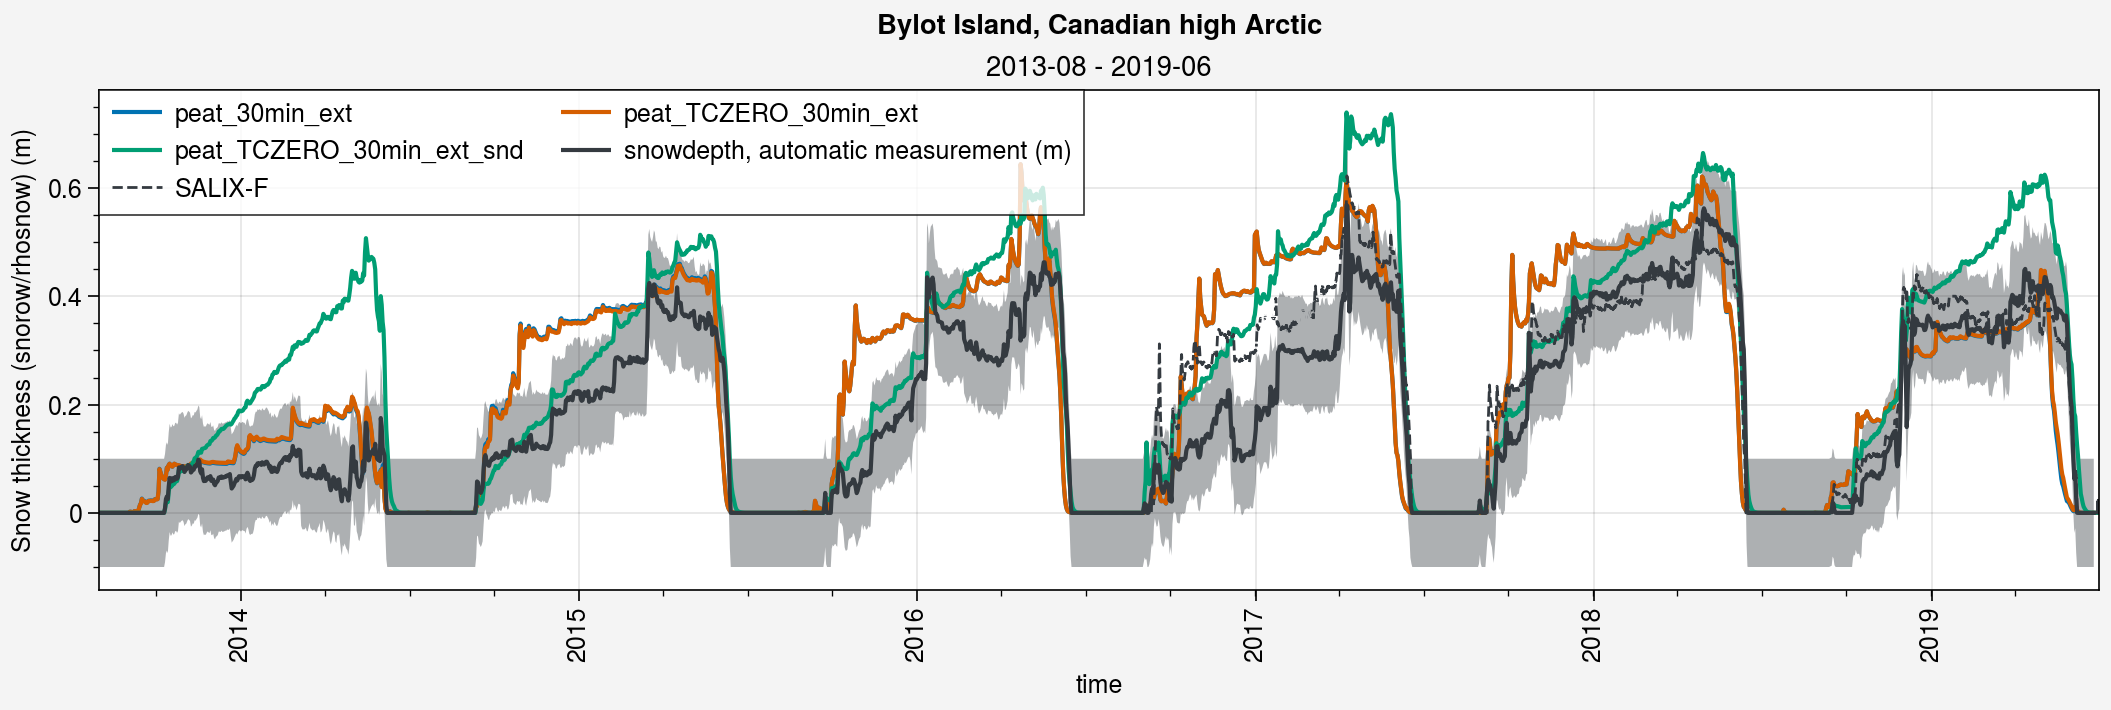

In [15]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-06')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-06')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snd.sel(time=period), label=label)
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_obs.snd_man.sel(time=period), marker='.', color=color_obs)

    axs[0].plot(ds_SALIX['SALIX-F'].sel(time=period), color=color_obs, ls='--', lw=1)
    

    # Veg
    # axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop)
    
    fig.suptitle(site_longname)


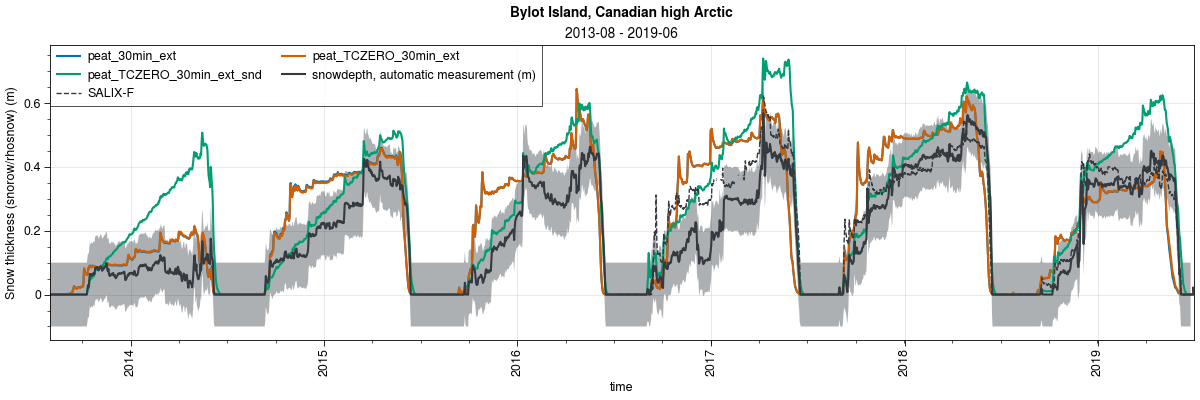

In [16]:
%matplotlib widget

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, figsize=(12,4))

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-06')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-06')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snd.sel(time=period), label=label)
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_obs.snd_man.sel(time=period), marker='.', color=color_obs)

    axs[0].plot(ds_SALIX['SALIX-F'].sel(time=period), color=color_obs, ls='--', lw=1)
    

    # Veg
    # axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop)
    
    fig.suptitle(site_longname)


### SWE

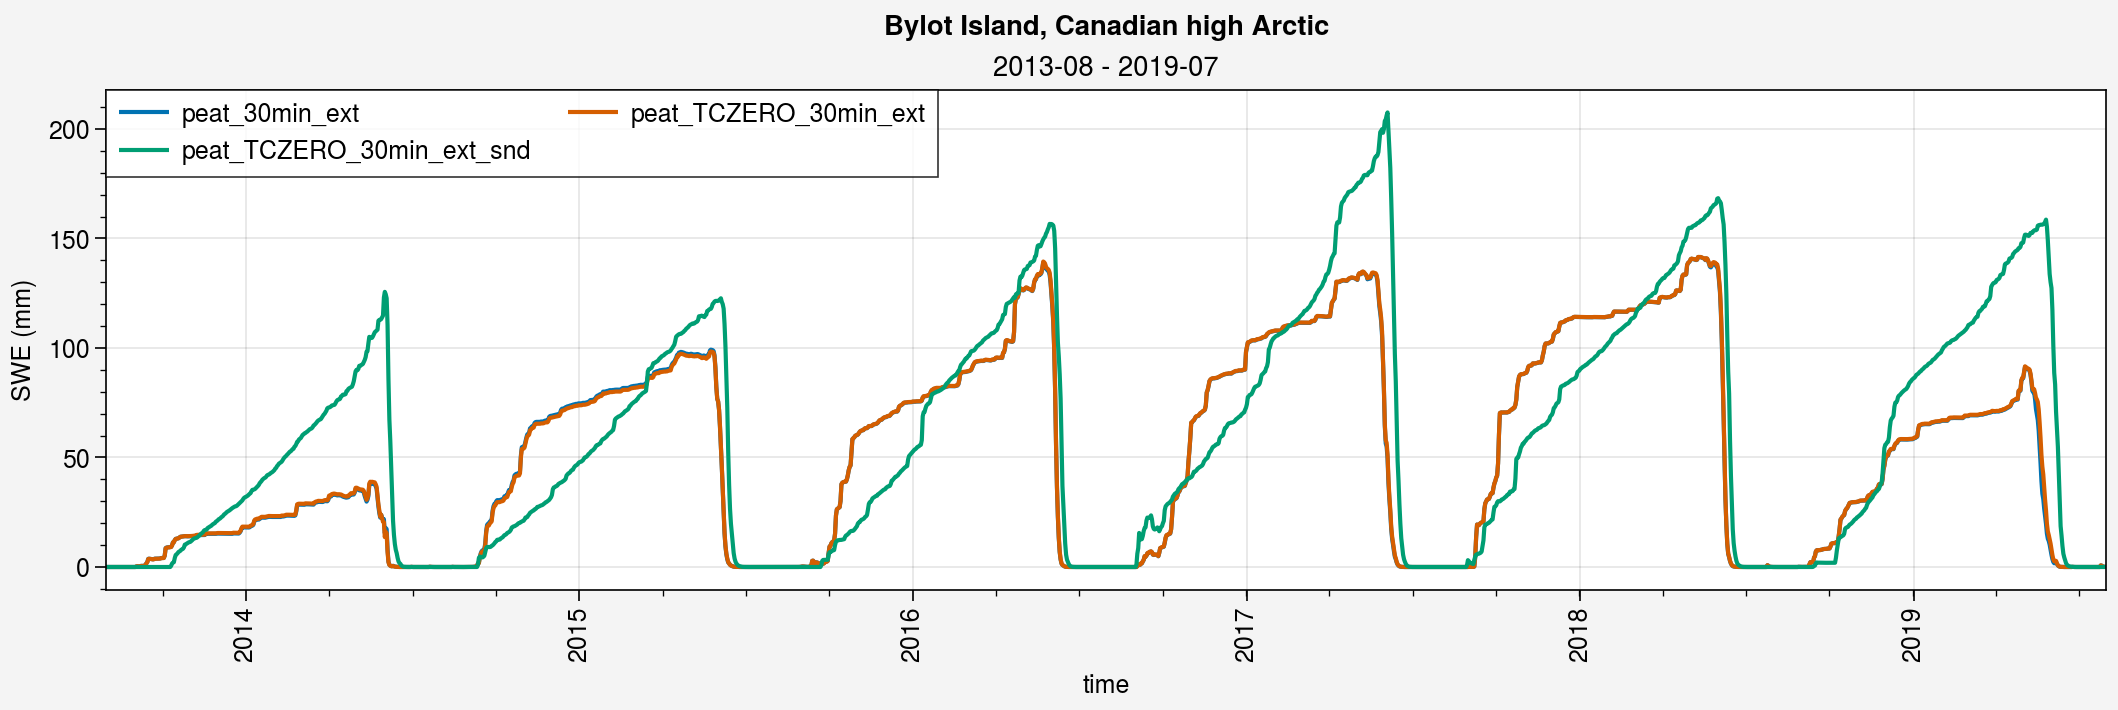

In [17]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snw.sel(time=period), label=label)
    
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values+25, axis=0),
    #     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values-25, axis=0),), axis=0)
    # axs[0].plot(ds_d_obs.snw_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_obs.snw_man.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='SWE (mm)')
    
    fig.suptitle(site_longname)


### Albedo

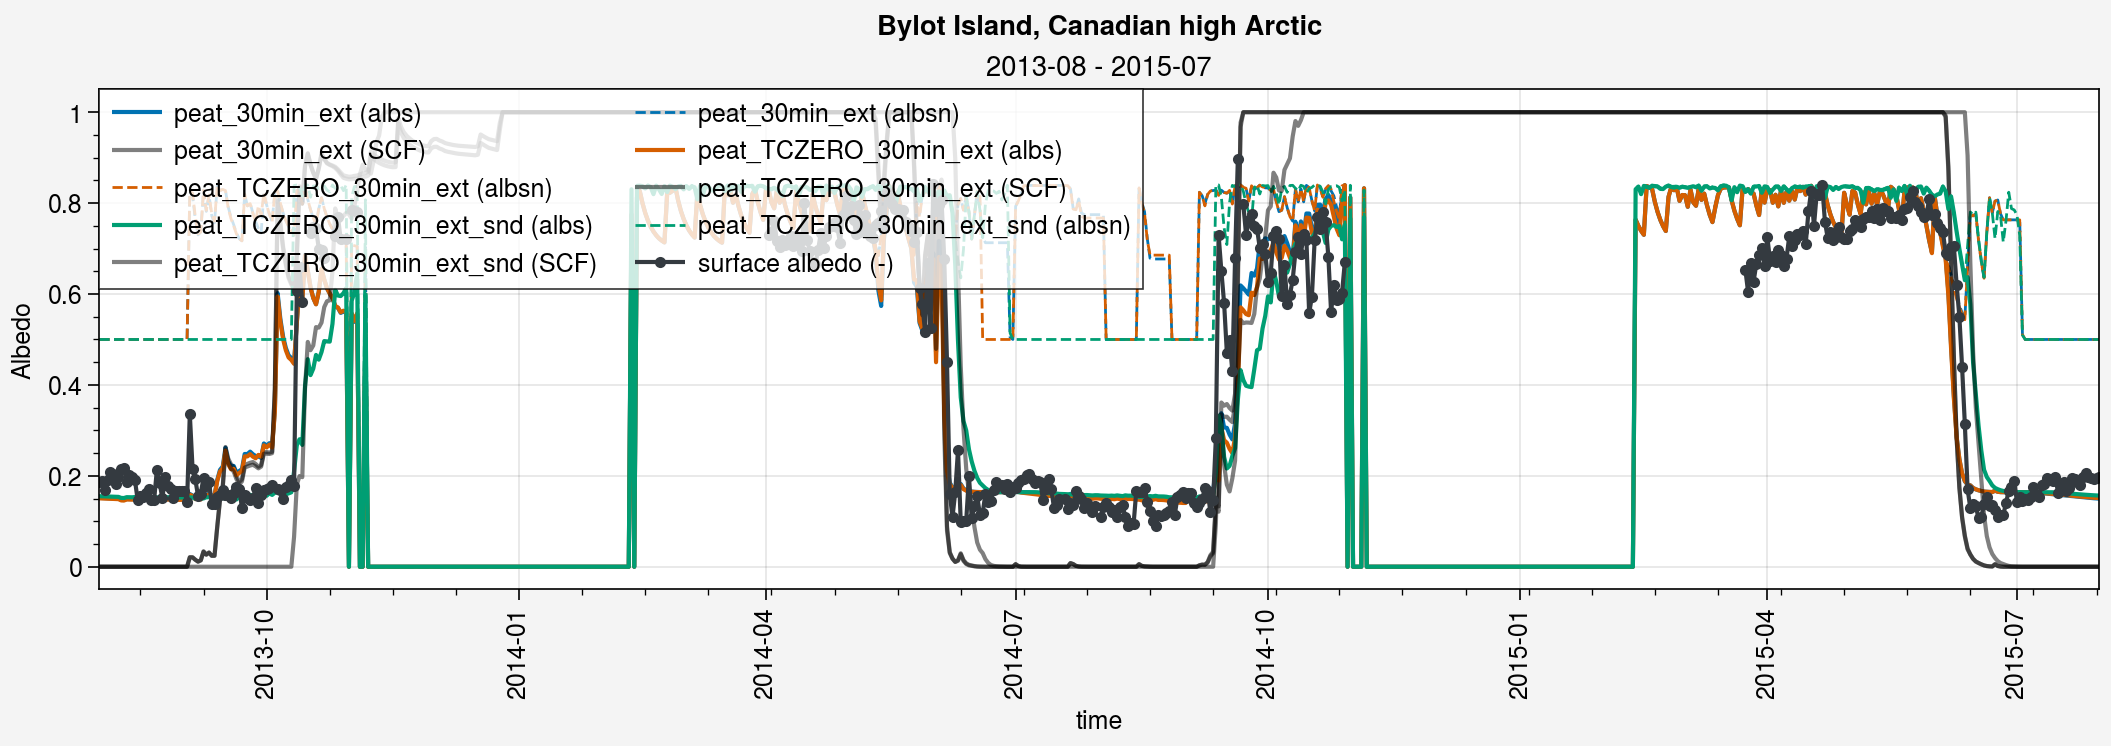

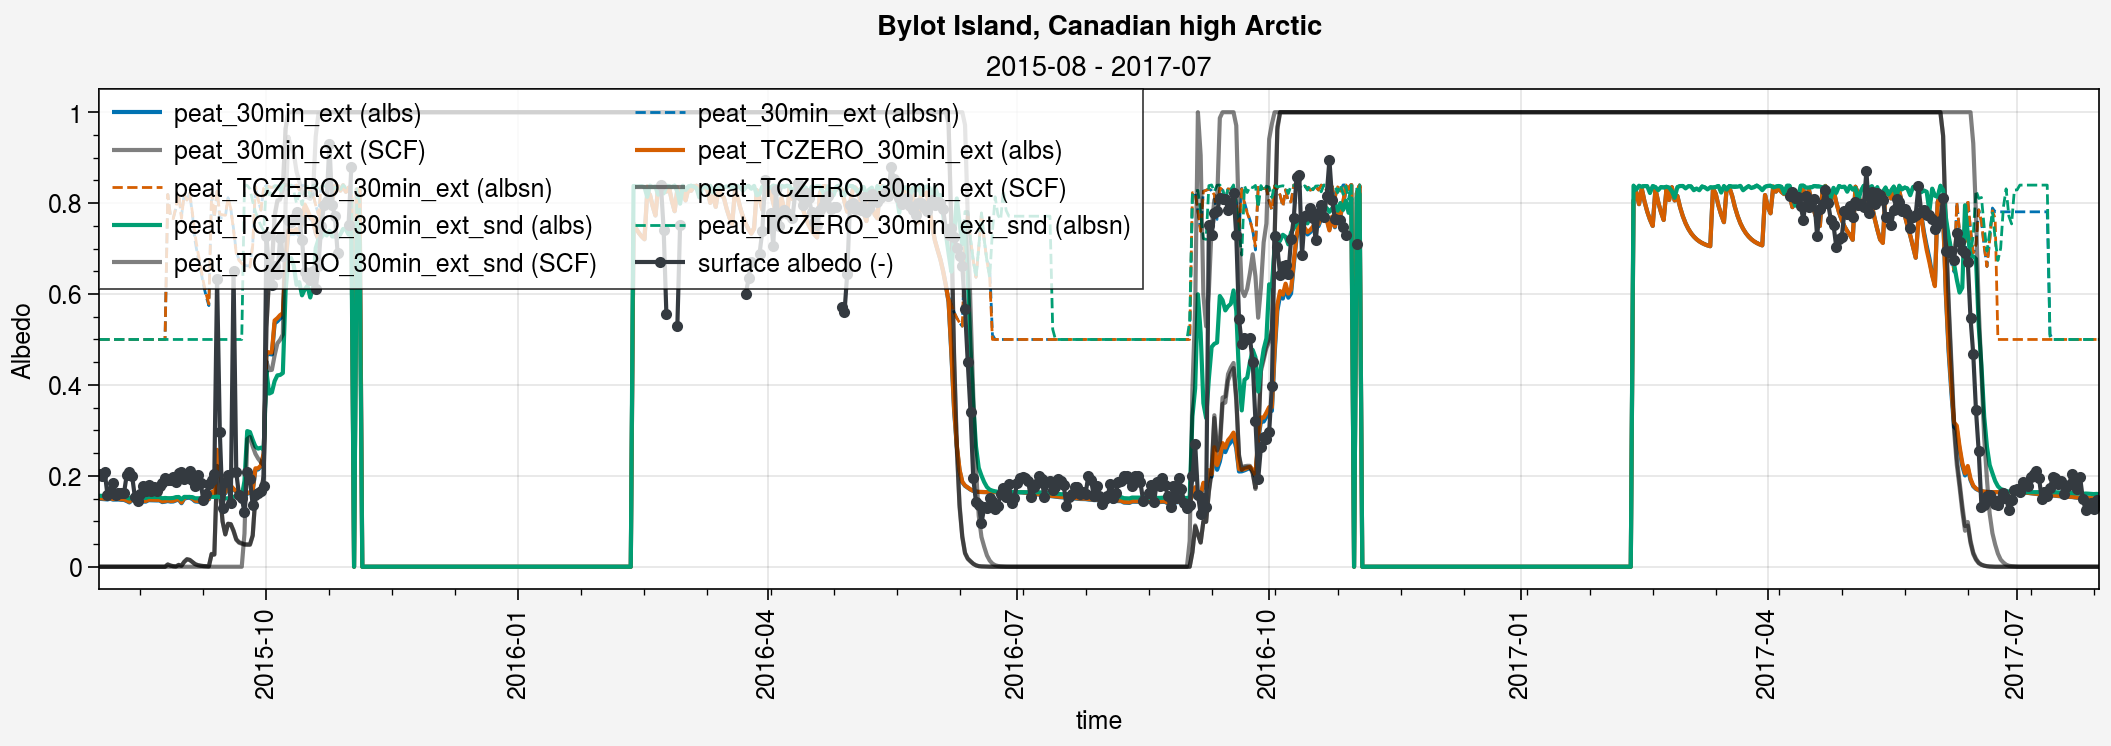

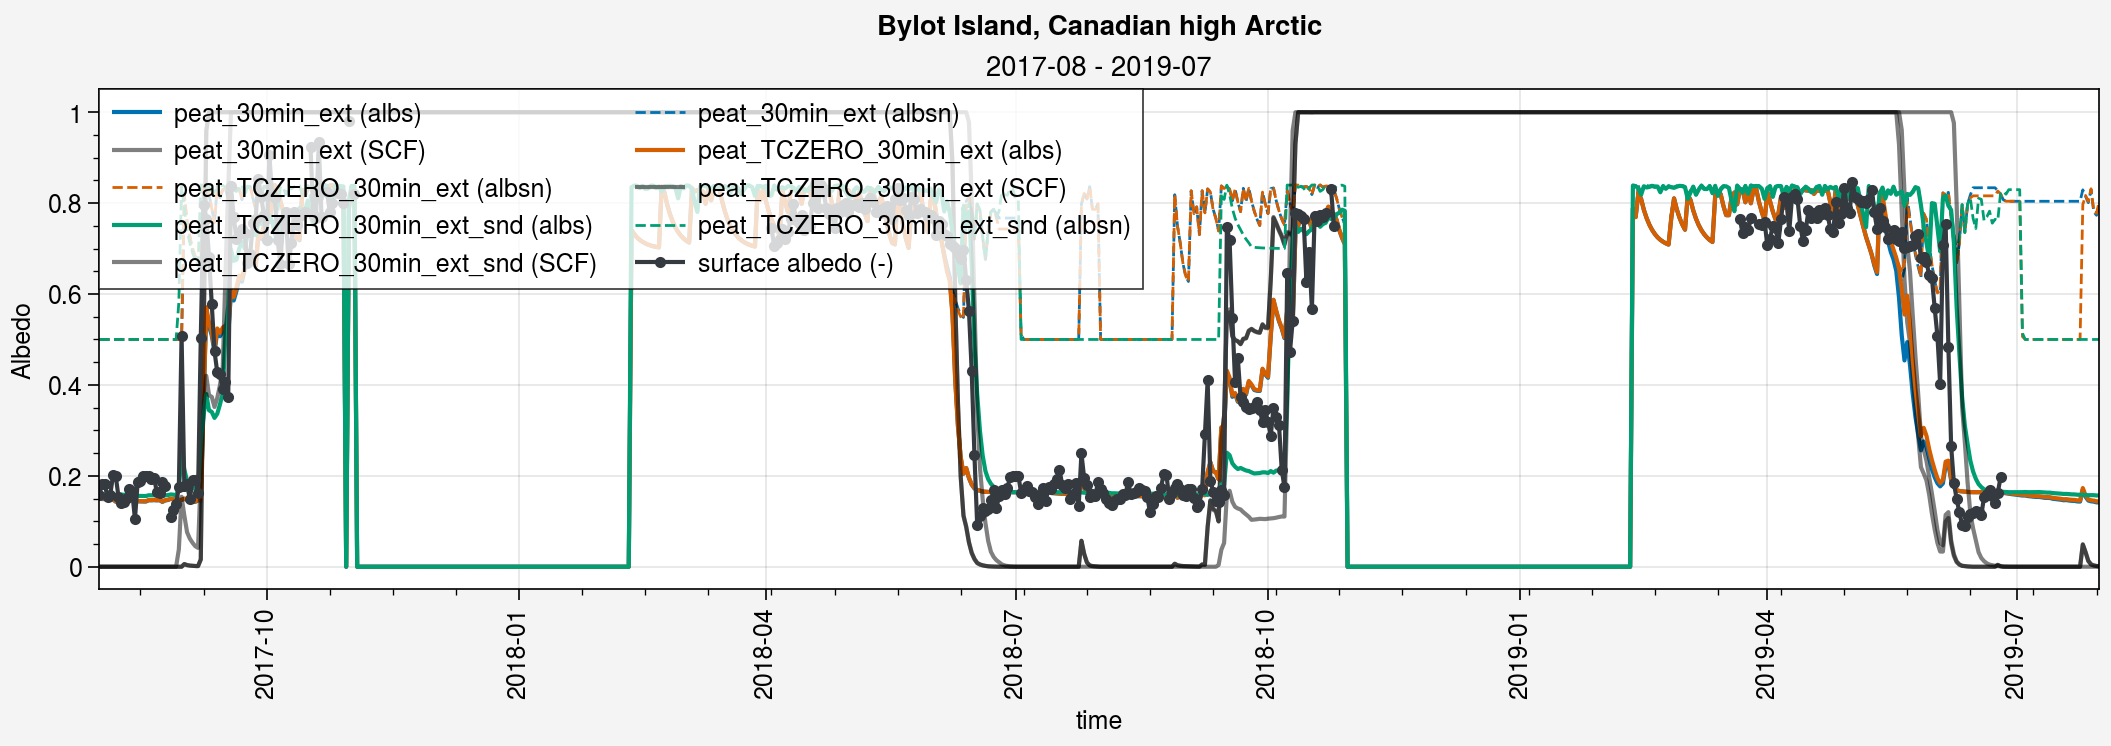

In [18]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    k = 0
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.albs.sel(time=period), label=label+' (albs)', color='C'+str(k))
        axs[0].plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', color='C'+str(k), ls='--', lw=1)
        axs[0].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)
        
        k+=1
    
    # Obs
    axs[0].plot(ds_d_obs.albs.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Albedo')
    
    fig.suptitle(site_longname)


### Surface Temperature

Domine et al. ([2019](https://onlinelibrary.wiley.com/doi/abs/10.1029/2018MS001445)): "**Averaged over a period of several days the surface temperatures are essentially the same**. The amplitude variations are greater in the Alpine snowpack (Figure 8b) because the insulating layer at the top does not allow damping the air temperature variations by heat exchanges with the snowpack. This effect is more important in April and May, when daily temperature variations reach 20 °C, sometimes more. The absolute temperature differences reaches 4.7 °C on 8 February, when the temperature suddenly increases by 15 °C in 5 hr, and the surface temperature of the Alpine snowpack increases more rapidly."

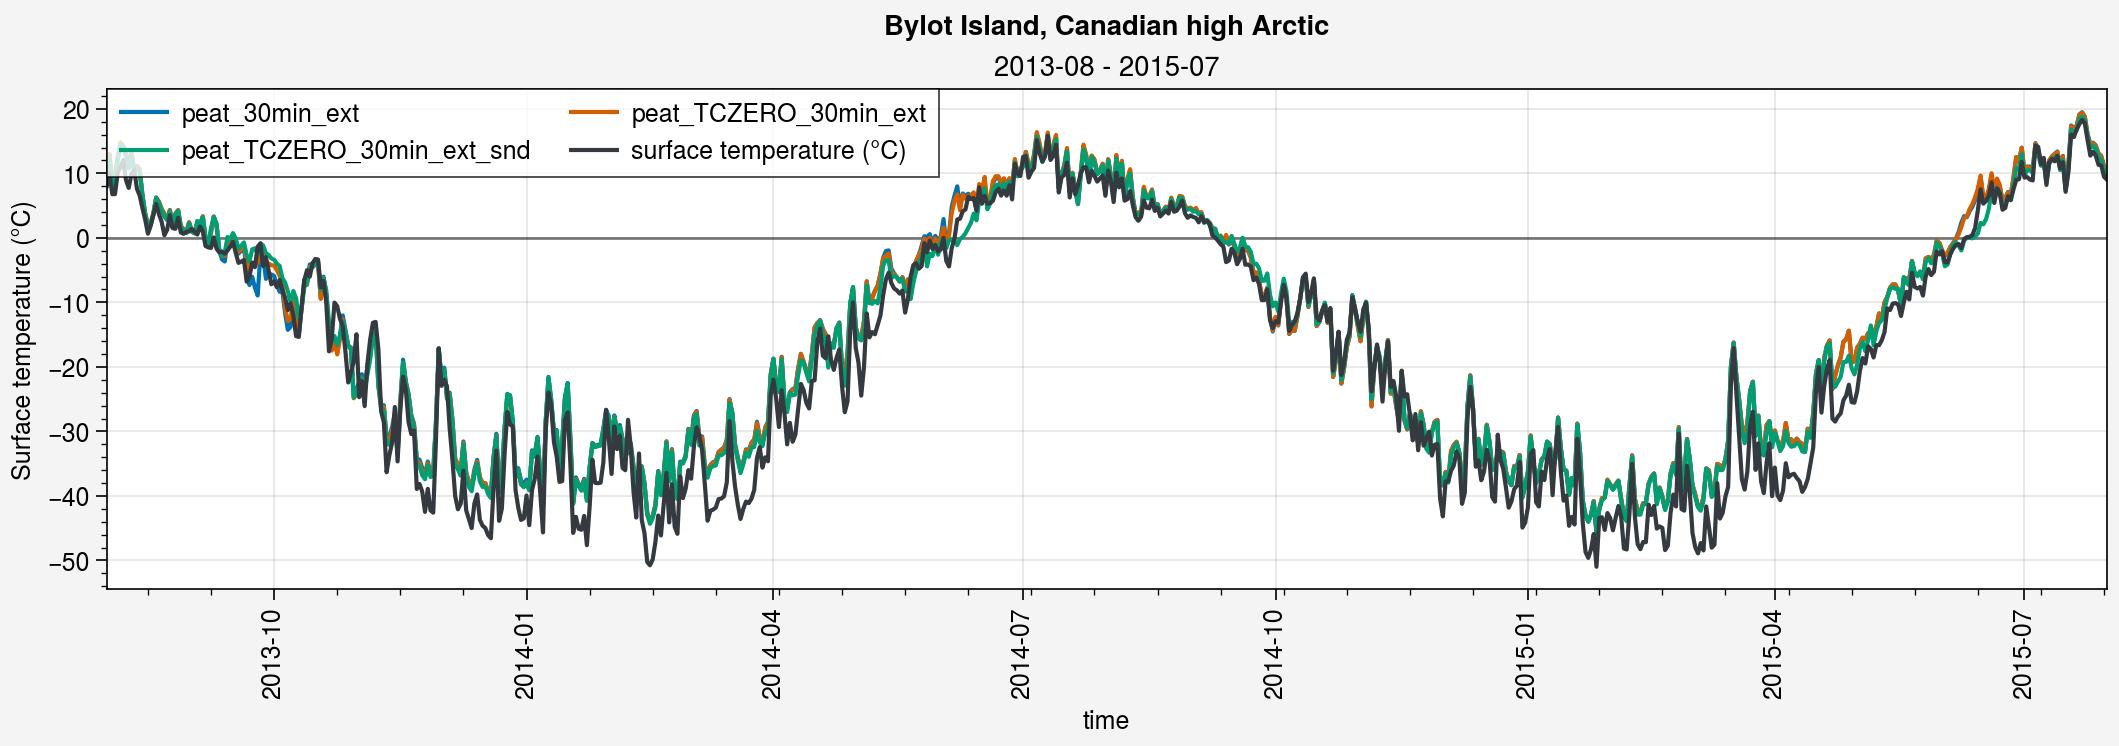

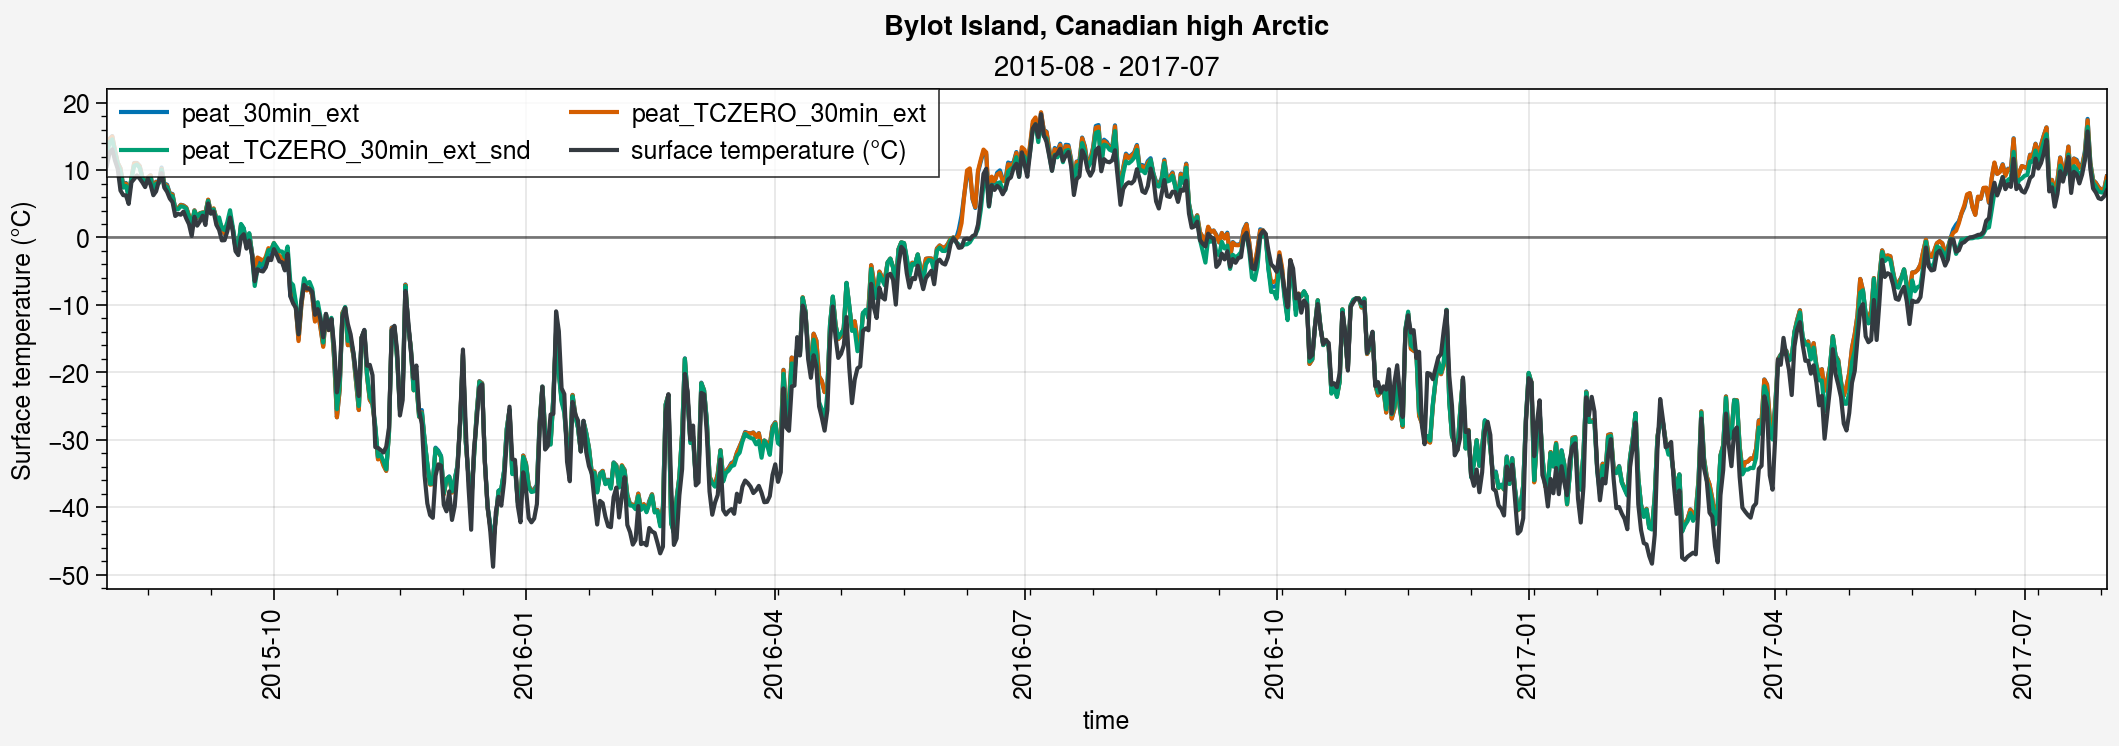

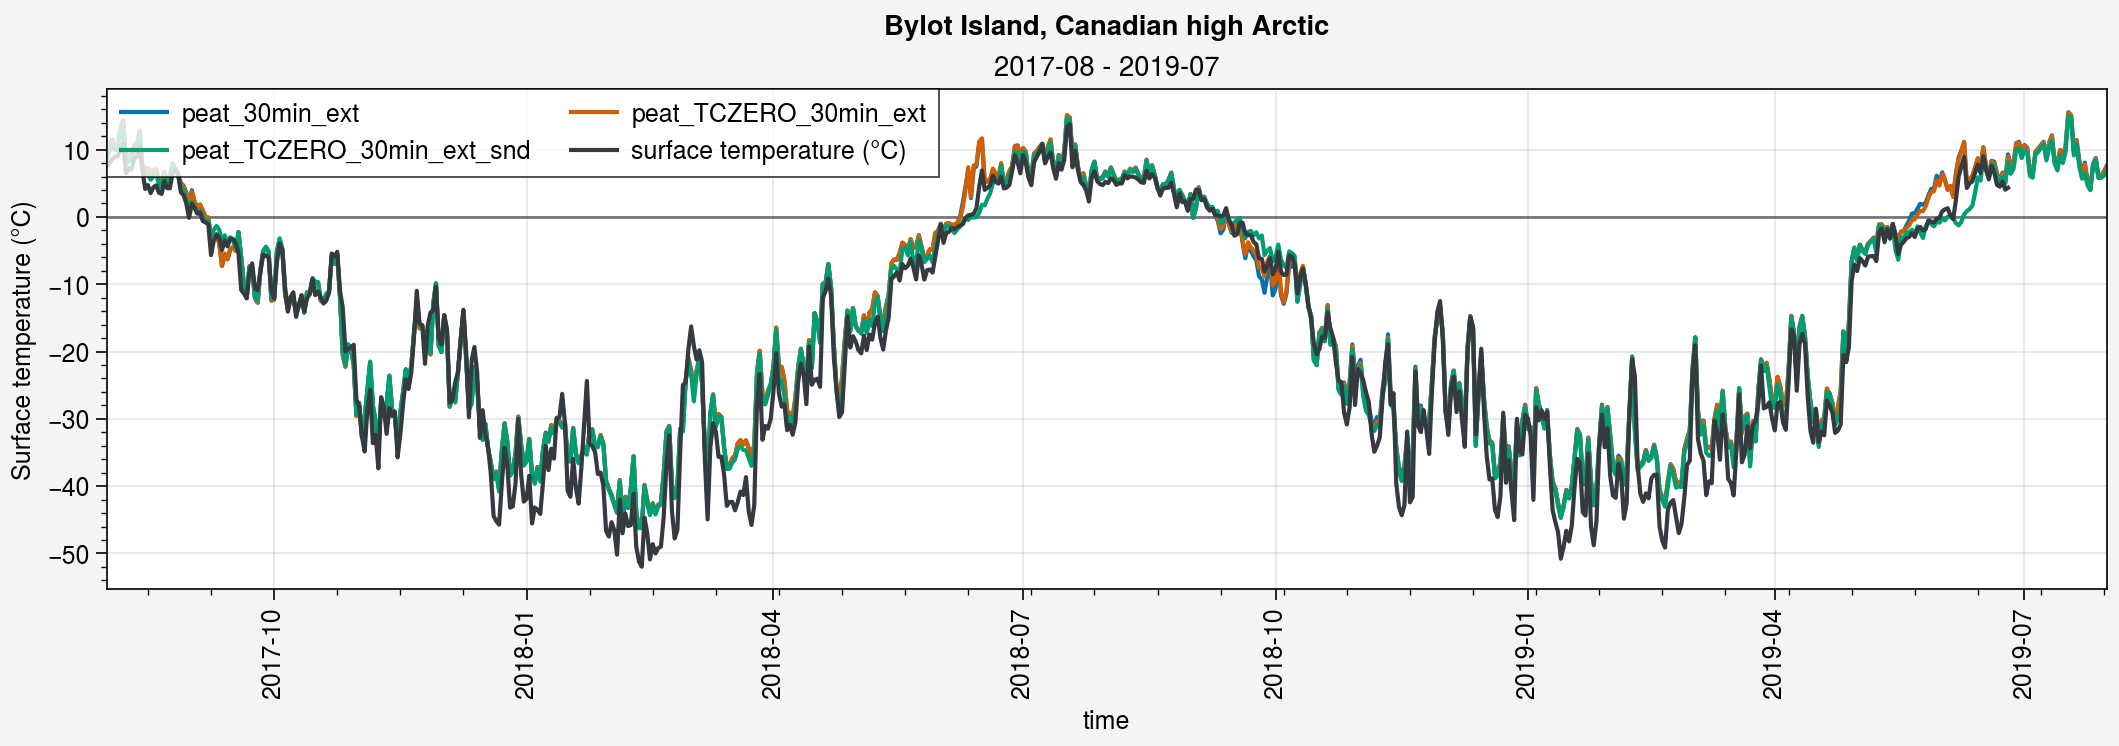

In [19]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.ts.sel(time=period)-273.15, label=label)
    
    # Obs
    axs[0].plot(ds_d_obs.ts.sel(time=period), color=color_obs)
    axs[0].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Surface temperature (°C)')
    
    fig.suptitle(site_longname)


### Soil Temperature

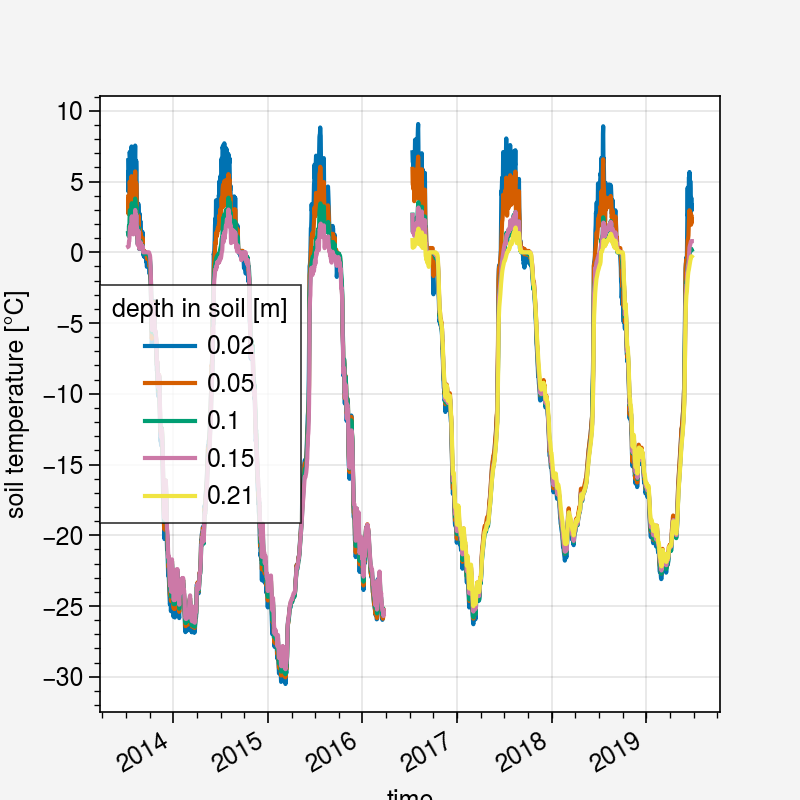

In [62]:
%matplotlib inline
ds_d_obs.tsl.plot(hue='sdepth')

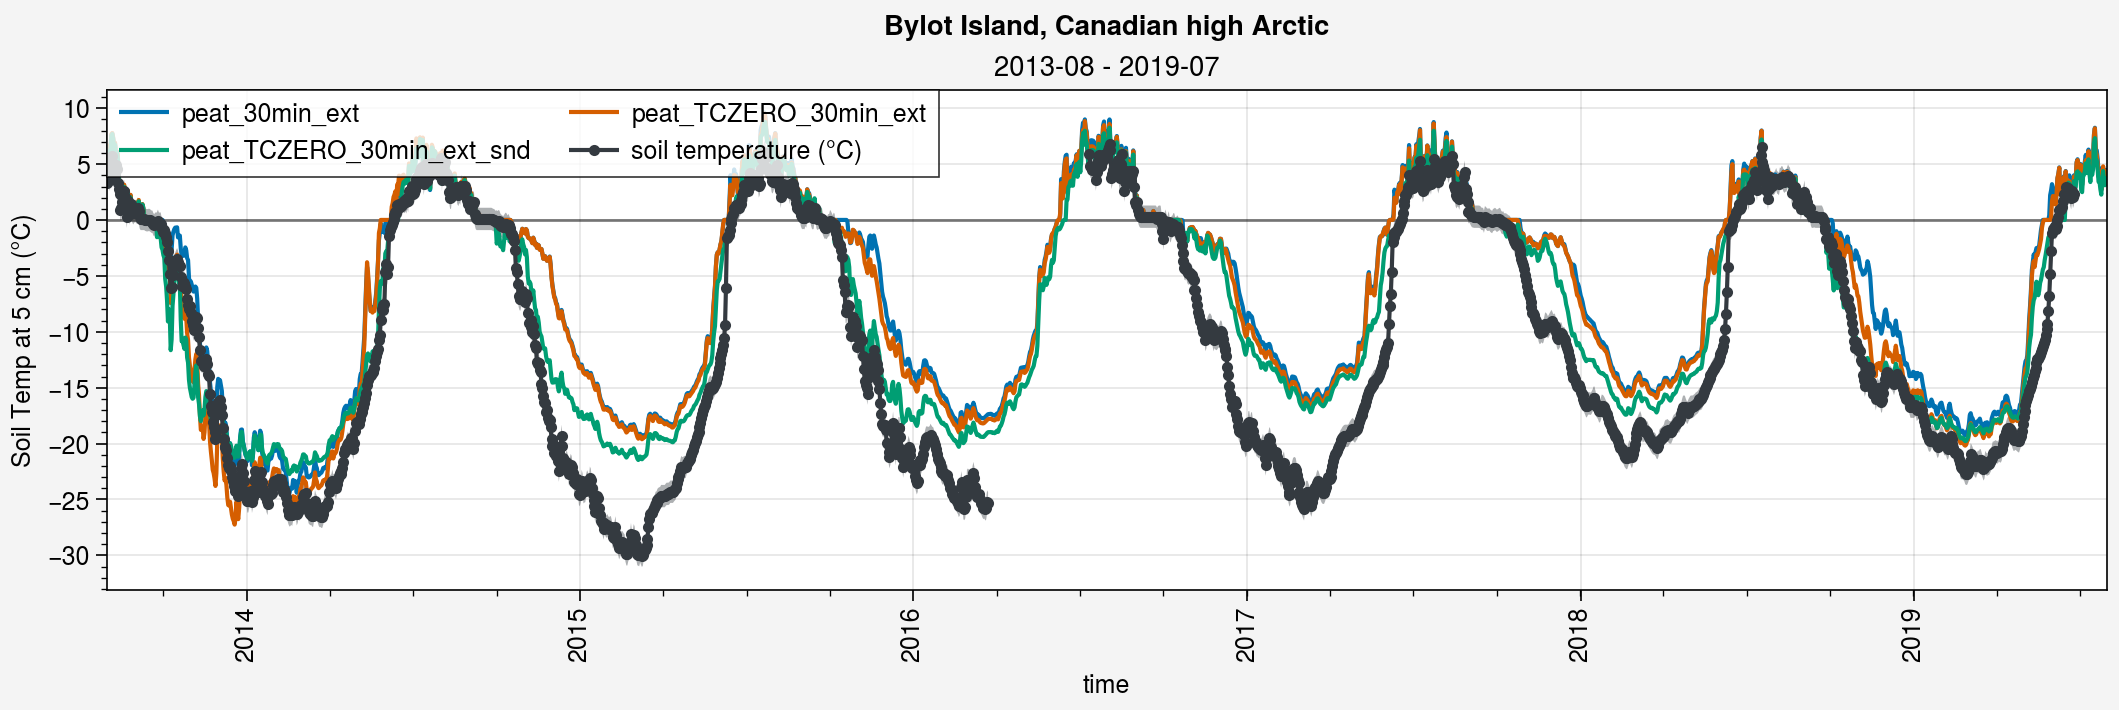

In [20]:
%matplotlib inline
gap = 6
color_obs = 'gray8'
sdepth = 0.05
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        # axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).sel(layer=sdepth)-273.15, label=label)
        
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
        np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at '+sdepth_label+' cm (°C)')
    
    fig.suptitle(site_longname)


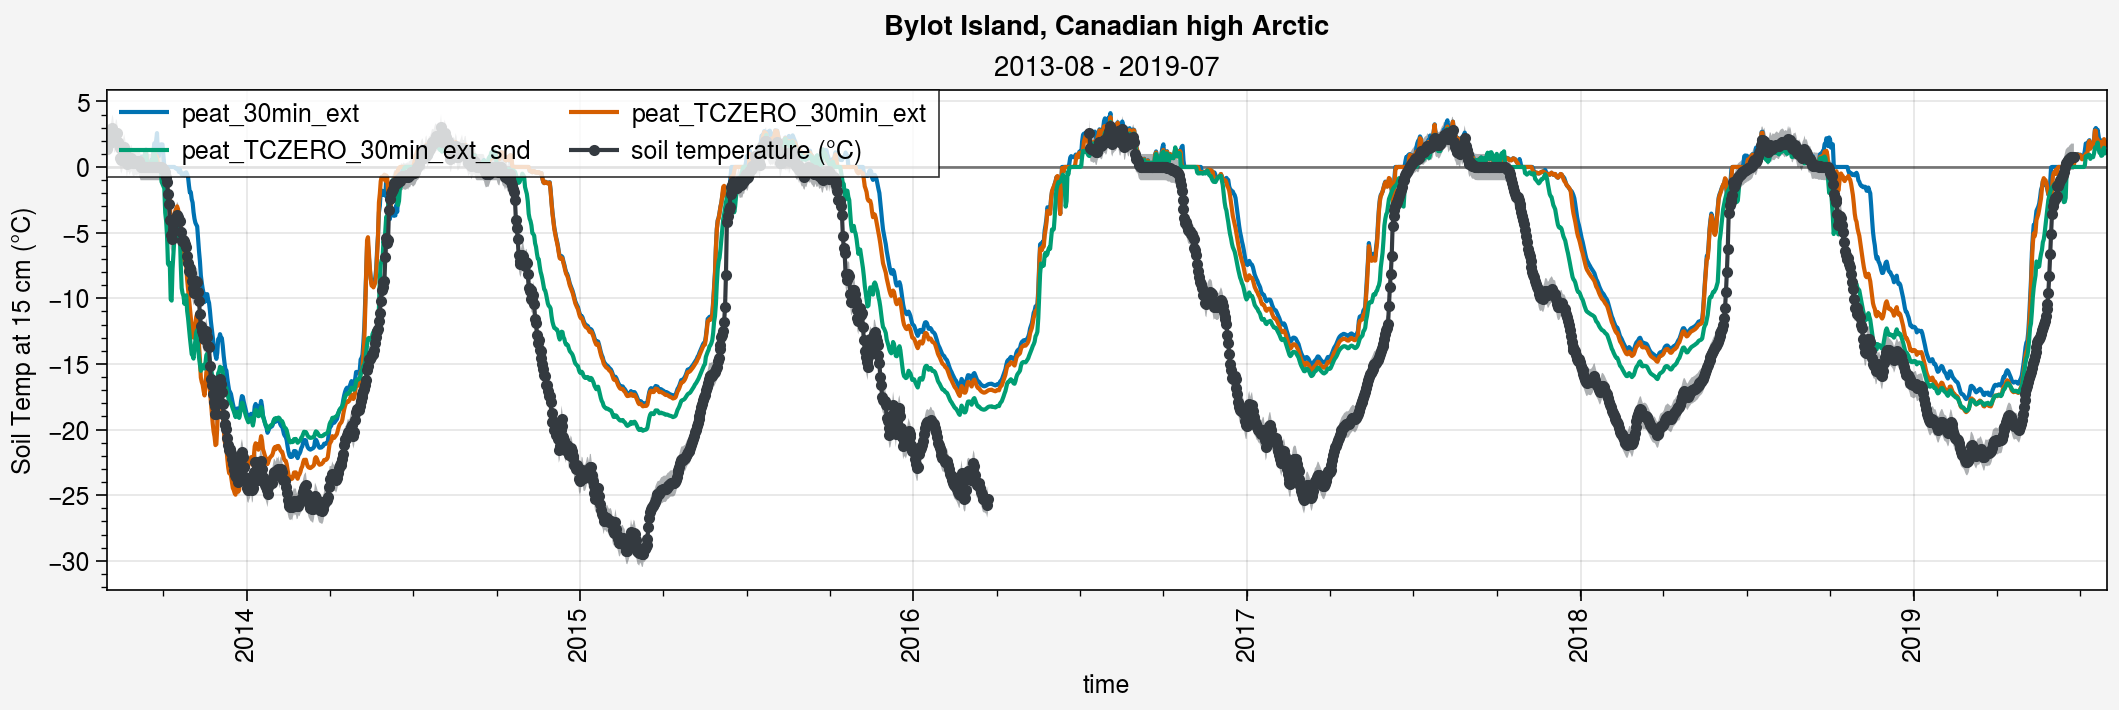

In [21]:
%matplotlib inline
gap = 6
color_obs = 'gray8'
sdepth = 0.15
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        # axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).sel(layer=sdepth, method='nearest')-273.15, label=label)
        
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
        np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at '+sdepth_label+' cm (°C)')
    
    fig.suptitle(site_longname)


### Snow temperature

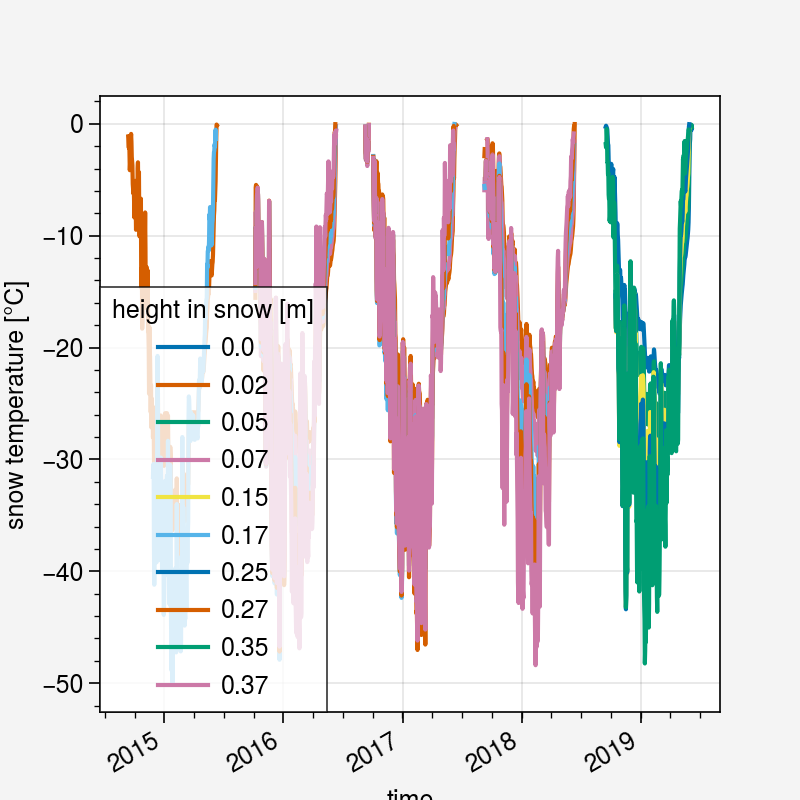

In [66]:
ds_d_obs.tsnl.plot(hue='sheight')

In [22]:
ds_d_obs.tsnl

<xarray.DataArray 'tsnl' (time: 2176, sheight: 10)> Size: 174kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * sheight  (sheight) float64 80B 0.0 0.02 0.05 0.07 ... 0.25 0.27 0.35 0.37
  * time     (time) datetime64[ns] 17kB 2013-07-11 2013-07-12 ... 2019-06-25
Attributes:
    long_name:  snow temperature
    units:      °C

In [45]:
ds_d_obs.tsnl

<xarray.DataArray 'tsnl' (time: 2176, sheight: 10)> Size: 174kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * sheight  (sheight) float64 80B 0.0 0.02 0.05 0.07 ... 0.25 0.27 0.35 0.37
  * time     (time) datetime64[ns] 17kB 2013-07-11 2013-07-12 ... 2019-06-25
Attributes:
    long_name:  snow temperature
    units:      °C

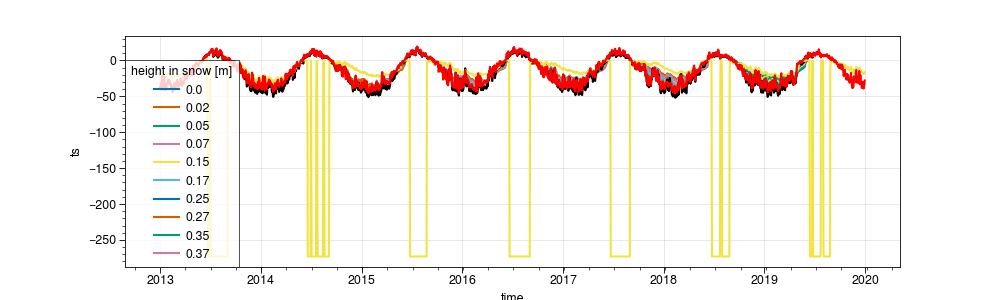

In [184]:
%matplotlib widget
plt.figure(figsize=(10,3))
ds_d_obs.tsnl.plot(hue='sheight')
ds_d_obs.ts.plot(color='black')
(ds_d_list[0].tsn-273.15).plot()
(ds_d_list[0].ts-273.15).plot(color='red')


In [64]:
ds_d_obs.tsl

<xarray.DataArray 'tsl' (time: 2176, sdepth: 5)> Size: 87kB
array([[ 6.49733333,  3.928     ,  1.35666667,  0.38933333,         nan],
       [ 4.31208333,  2.74625   ,  1.28666667,  0.39875   ,         nan],
       [ 4.26333333,  2.69166667,  1.13833333,  0.43      ,         nan],
       ...,
       [ 3.85416667,  2.64125   ,  0.25291667,  0.79      , -0.3       ],
       [ 2.94666667,  2.07041667,  0.20333333,  0.79      , -0.28333333],
       [ 3.30545455,  2.31181818,  0.16818182,  0.79      , -0.3       ]])
Coordinates:
  * sdepth   (sdepth) float64 40B 0.02 0.05 0.1 0.15 0.21
  * time     (time) datetime64[ns] 17kB 2013-07-11 2013-07-12 ... 2019-06-25
Attributes:
    long_name:  soil temperature
    units:      °C

In [78]:
ds_d_obs.tsnl.sel(time=date).dropna(dim='sheight').

<xarray.DataArray 'sheight' (sheight: 5)> Size: 40B
array([0.02, 0.07, 0.17, 0.27, 0.37])
Coordinates:
  * sheight  (sheight) float64 40B 0.02 0.07 0.17 0.27 0.37
    time     datetime64[ns] 8B 2016-02-01
Attributes:
    long_name:  height in snow
    units:      m

In [105]:
ds_d_list[0].sel(time=date).tsn.values

array(254.41774382)

In [112]:
ds_hh_list[0].tsn

<xarray.DataArray 'tsn' (time: 35040)> Size: 280kB
array([-16.68159045, -16.77893327, -16.86983328, ..., -17.02230521,
       -17.02376865, -17.02532284])
Coordinates:
  * time     (time) datetime64[ns] 280kB 2013-01-01 ... 2014-12-31T23:30:00
Attributes:
    long_name:   Bulk temperature of the snow, not the surface (skin) tempera...
    units:       $^\circ$C
    nameInCode:  tsno_hh

In [116]:
ds_d_list[0].sel(time=date).ts-273.15

<xarray.DataArray 'ts' ()> Size: 8B
array(-37.09220954)
Coordinates:
    time     datetime64[ns] 8B 2016-02-01

In [121]:
b

array(4479.7903048)

In [134]:
date = '2016-02-01'
def T(z, a, b, c):
    return 1/2*a*z**2 + b*z + c

z = np.linspace(0, ds_d_list[0].sel(time=date).snd.squeeze())
c = (ds_d_list[0].sel(time=date).ts).values
b = ((-3/ds_d_list[0].sel(time=date).snd)*(c-ds_d_list[0].sel(time=date).tsn.values)).values
a = (-b/ds_d_list[0].sel(time=date).snd).values
tsn_theoric = T(z, a, b, c)

tsn_th = np.trapz(tsn_theoric, x=z)/z[-1]
# print('Snow temperature from obs: {:.2f}'.format(tsn_obs)+' °C')
print('Theoric snow temperature (model): {:.2f}'.format(tsn_th.item(0)-273.15)+' °C')
print('Snow temperature from model: {:.2f}'.format(ds_d.sel(time=date).tsn.values.item(0)-273.15)+' °C')

Theoric snow temperature (model): -18.73 °C
Snow temperature from model: -19.29 °C


In [149]:
pd.date_range('2016-02-01', '2016-02-15')

DatetimeIndex(['2016-02-01', '2016-02-02', '2016-02-03', '2016-02-04',
               '2016-02-05', '2016-02-06', '2016-02-07', '2016-02-08',
               '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12',
               '2016-02-13', '2016-02-14', '2016-02-15'],
              dtype='datetime64[ns]', freq='D')

In [153]:
data_range.size

5

In [158]:
round(data_range.size/ncols,)

1

In [156]:
int(data_range.size/ncols)

1

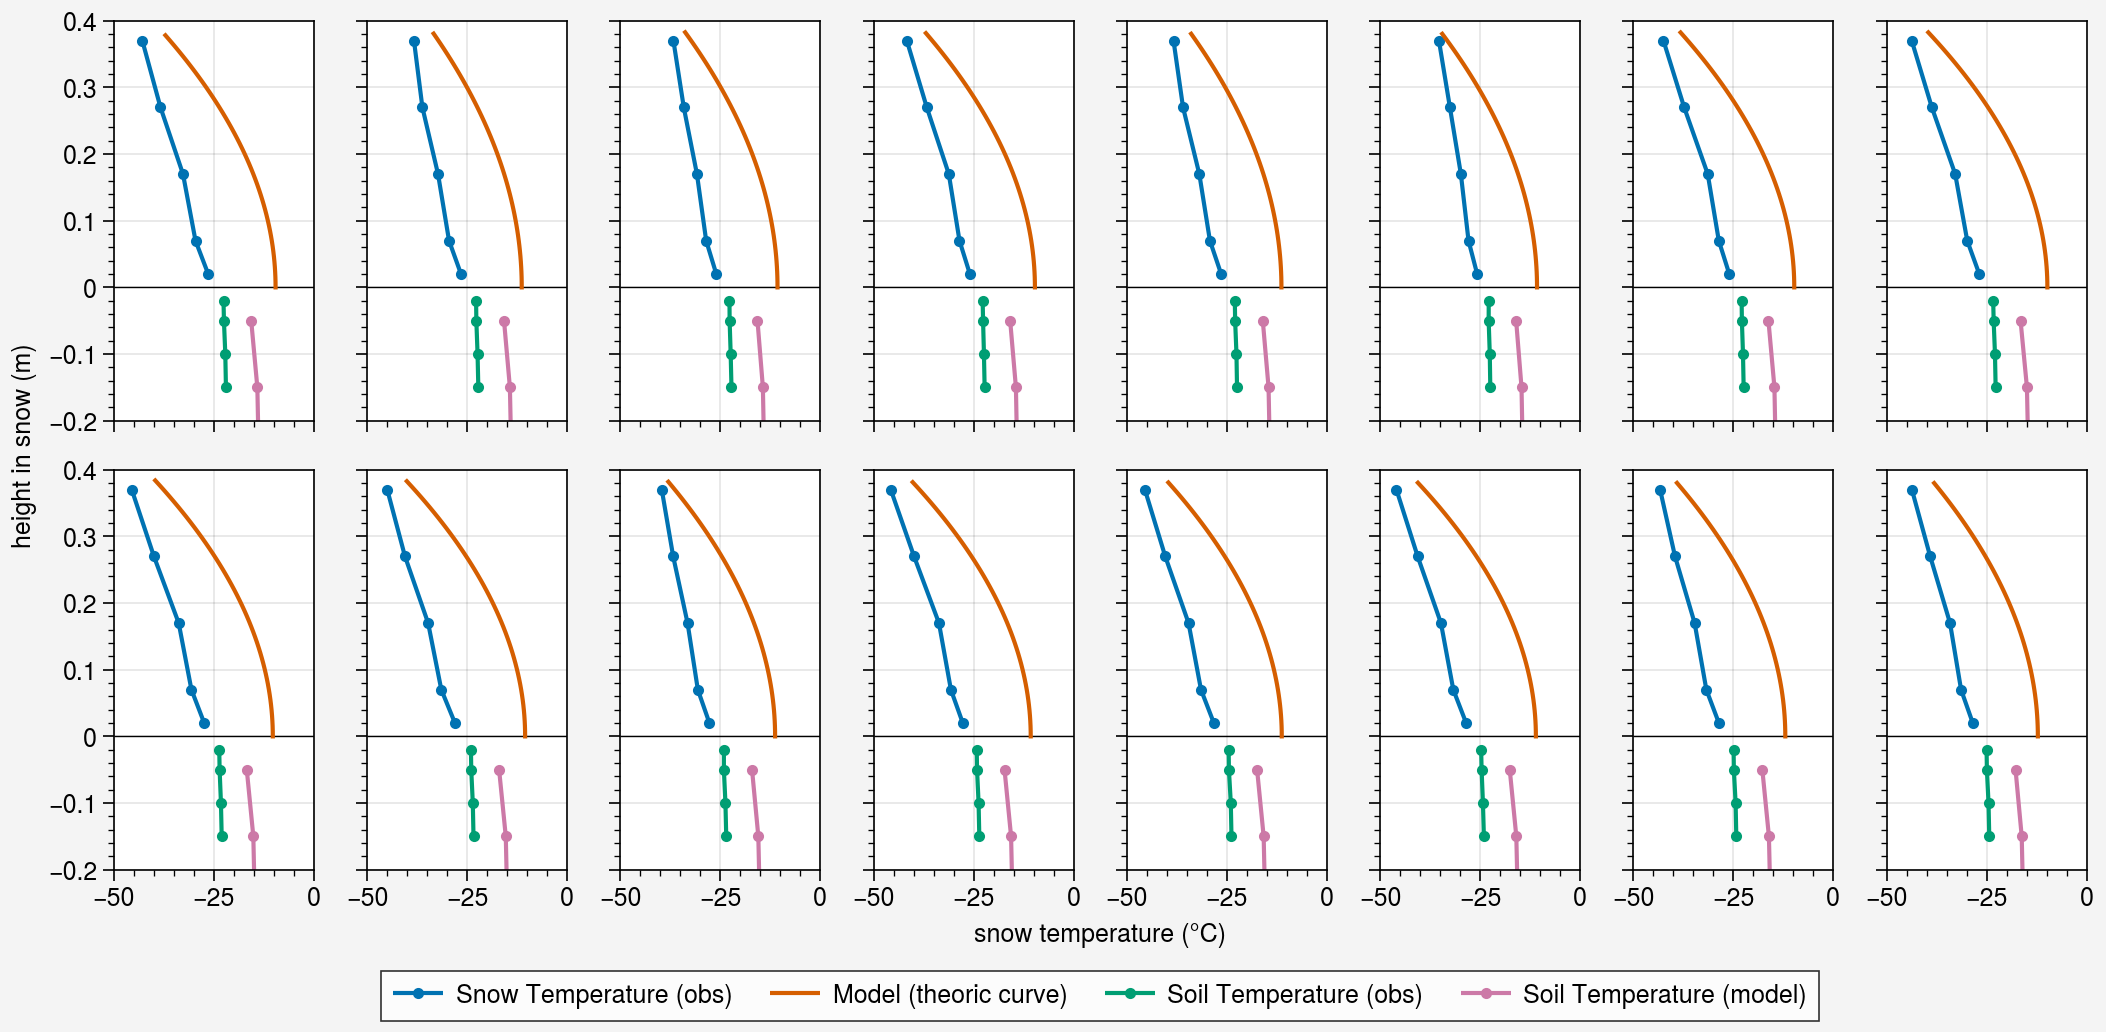

In [192]:
%matplotlib inline
import math
data_range = pd.date_range('2016-02-01', '2016-02-16')
# data_range = pd.date_range('2017-02-01', '2017-02-16')
ncols = 8
fig, axs = pplt.subplots(refaspect=0.5, ncols=ncols, nrows=math.ceil(data_range.size/ncols), refwidth=1)

for i, date in enumerate(data_range):

    z = np.linspace(0, ds_d_list[0].sel(time=date).snd.squeeze())
    c = (ds_d_list[0].sel(time=date).ts).values
    b = ((-3/ds_d_list[0].sel(time=date).snd)*(c-ds_d_list[0].sel(time=date).tsn.values)).values
    a = (-b/ds_d_list[0].sel(time=date).snd).values
    tsn_theoric = T(z, a, b, c)
    
    axs[i].plot(ds_d_obs.tsnl.sel(time=date).dropna(dim='sheight'), ds_d_obs.tsnl.sel(time=date).dropna(dim='sheight').sheight, 
                label='Snow Temperature (obs)', marker='.')
    # axs[i].plot(ds_d_obs.ts.sel(time=date), ds_d_obs.snd_auto.sel(time=date), label='Surace Temperature (obs)', marker='.')

    axs[i].plot(tsn_theoric.squeeze()-273.15, z[::-1], label='Model (theoric curve)')
    
    
    # axs[0].plot(ds_d_obs.tsl.sel(time=date, sdepth=0.02), -0.02, label='Soil', marker='.')
    axs[i].plot(ds_d_obs.tsl.sel(time=date), -ds_d_obs.sdepth, label='Soil Temperature (obs)', marker='.')
    axs[i].plot(ds_d_list[0].tsl.sel(time=date)-273.15, -ds_d_list[0].layer, label='Soil Temperature (model)', marker='.')
    axs[i].format(xlim=(-50, 0), ylim=(-0.2, 0.4))
    axs[i].hlines(0, -50, 0, color='k', lw=0.5)
    if i == 0: fig.legend(loc='b', ncols=4)


    
# axs[0].format(xlabel='Snow Temperature (°C)', ylabel='Snow Depth (cm)', title=date,
#              lltitle='tsn_obs: {:.2f}'.format(tsn_obs)+' °C\ntsn_th: {:.2f}'.format(tsn_th.item(0))+' °C')

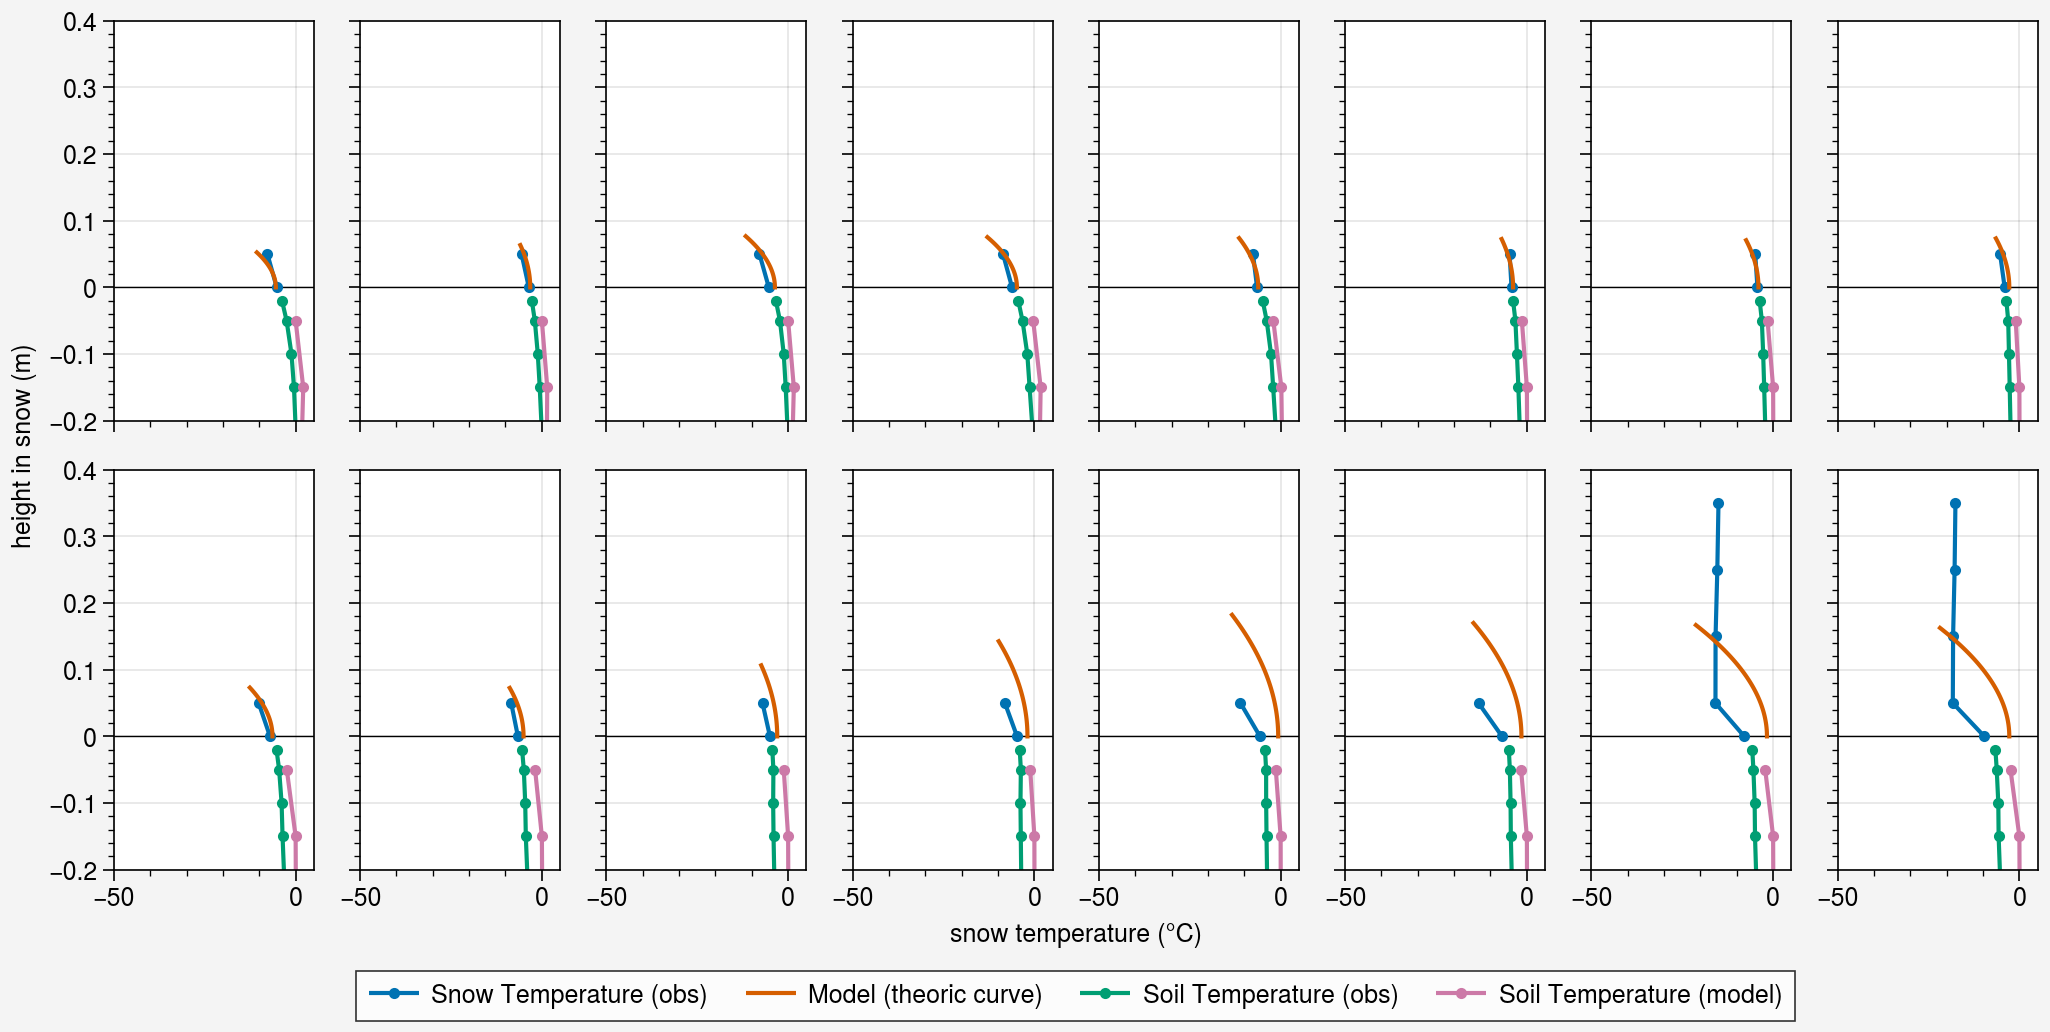

In [198]:
%matplotlib inline
import math
data_range = pd.date_range('2018-10-01', '2018-10-16')
# data_range = pd.date_range('2017-02-01', '2017-02-16')
ncols = 8
fig, axs = pplt.subplots(refaspect=0.5, ncols=ncols, nrows=math.ceil(data_range.size/ncols), refwidth=1)

for i, date in enumerate(data_range):

    z = np.linspace(0, ds_d_list[0].sel(time=date).snd.squeeze())
    c = (ds_d_list[0].sel(time=date).ts).values
    b = ((-3/ds_d_list[0].sel(time=date).snd)*(c-ds_d_list[0].sel(time=date).tsn.values)).values
    a = (-b/ds_d_list[0].sel(time=date).snd).values
    tsn_theoric = T(z, a, b, c)
    
    axs[i].plot(ds_d_obs.tsnl.sel(time=date).dropna(dim='sheight'), ds_d_obs.tsnl.sel(time=date).dropna(dim='sheight').sheight, 
                label='Snow Temperature (obs)', marker='.')
    # axs[i].plot(ds_d_obs.ts.sel(time=date), ds_d_obs.snd_auto.sel(time=date), label='Surace Temperature (obs)', marker='.')

    axs[i].plot(tsn_theoric.squeeze()-273.15, z[::-1], label='Model (theoric curve)')
    
    
    # axs[0].plot(ds_d_obs.tsl.sel(time=date, sdepth=0.02), -0.02, label='Soil', marker='.')
    axs[i].plot(ds_d_obs.tsl.sel(time=date), -ds_d_obs.sdepth, label='Soil Temperature (obs)', marker='.')
    axs[i].plot(ds_d_list[0].tsl.sel(time=date)-273.15, -ds_d_list[0].layer, label='Soil Temperature (model)', marker='.')
    axs[i].format(xlim=(-50, 5), ylim=(-0.2, 0.4))
    axs[i].hlines(0, -50, 5, color='k', lw=0.5)
    if i == 0: fig.legend(loc='b', ncols=4)


    
# axs[0].format(xlabel='Snow Temperature (°C)', ylabel='Snow Depth (cm)', title=date,
#              lltitle='tsn_obs: {:.2f}'.format(tsn_obs)+' °C\ntsn_th: {:.2f}'.format(tsn_th.item(0))+' °C')

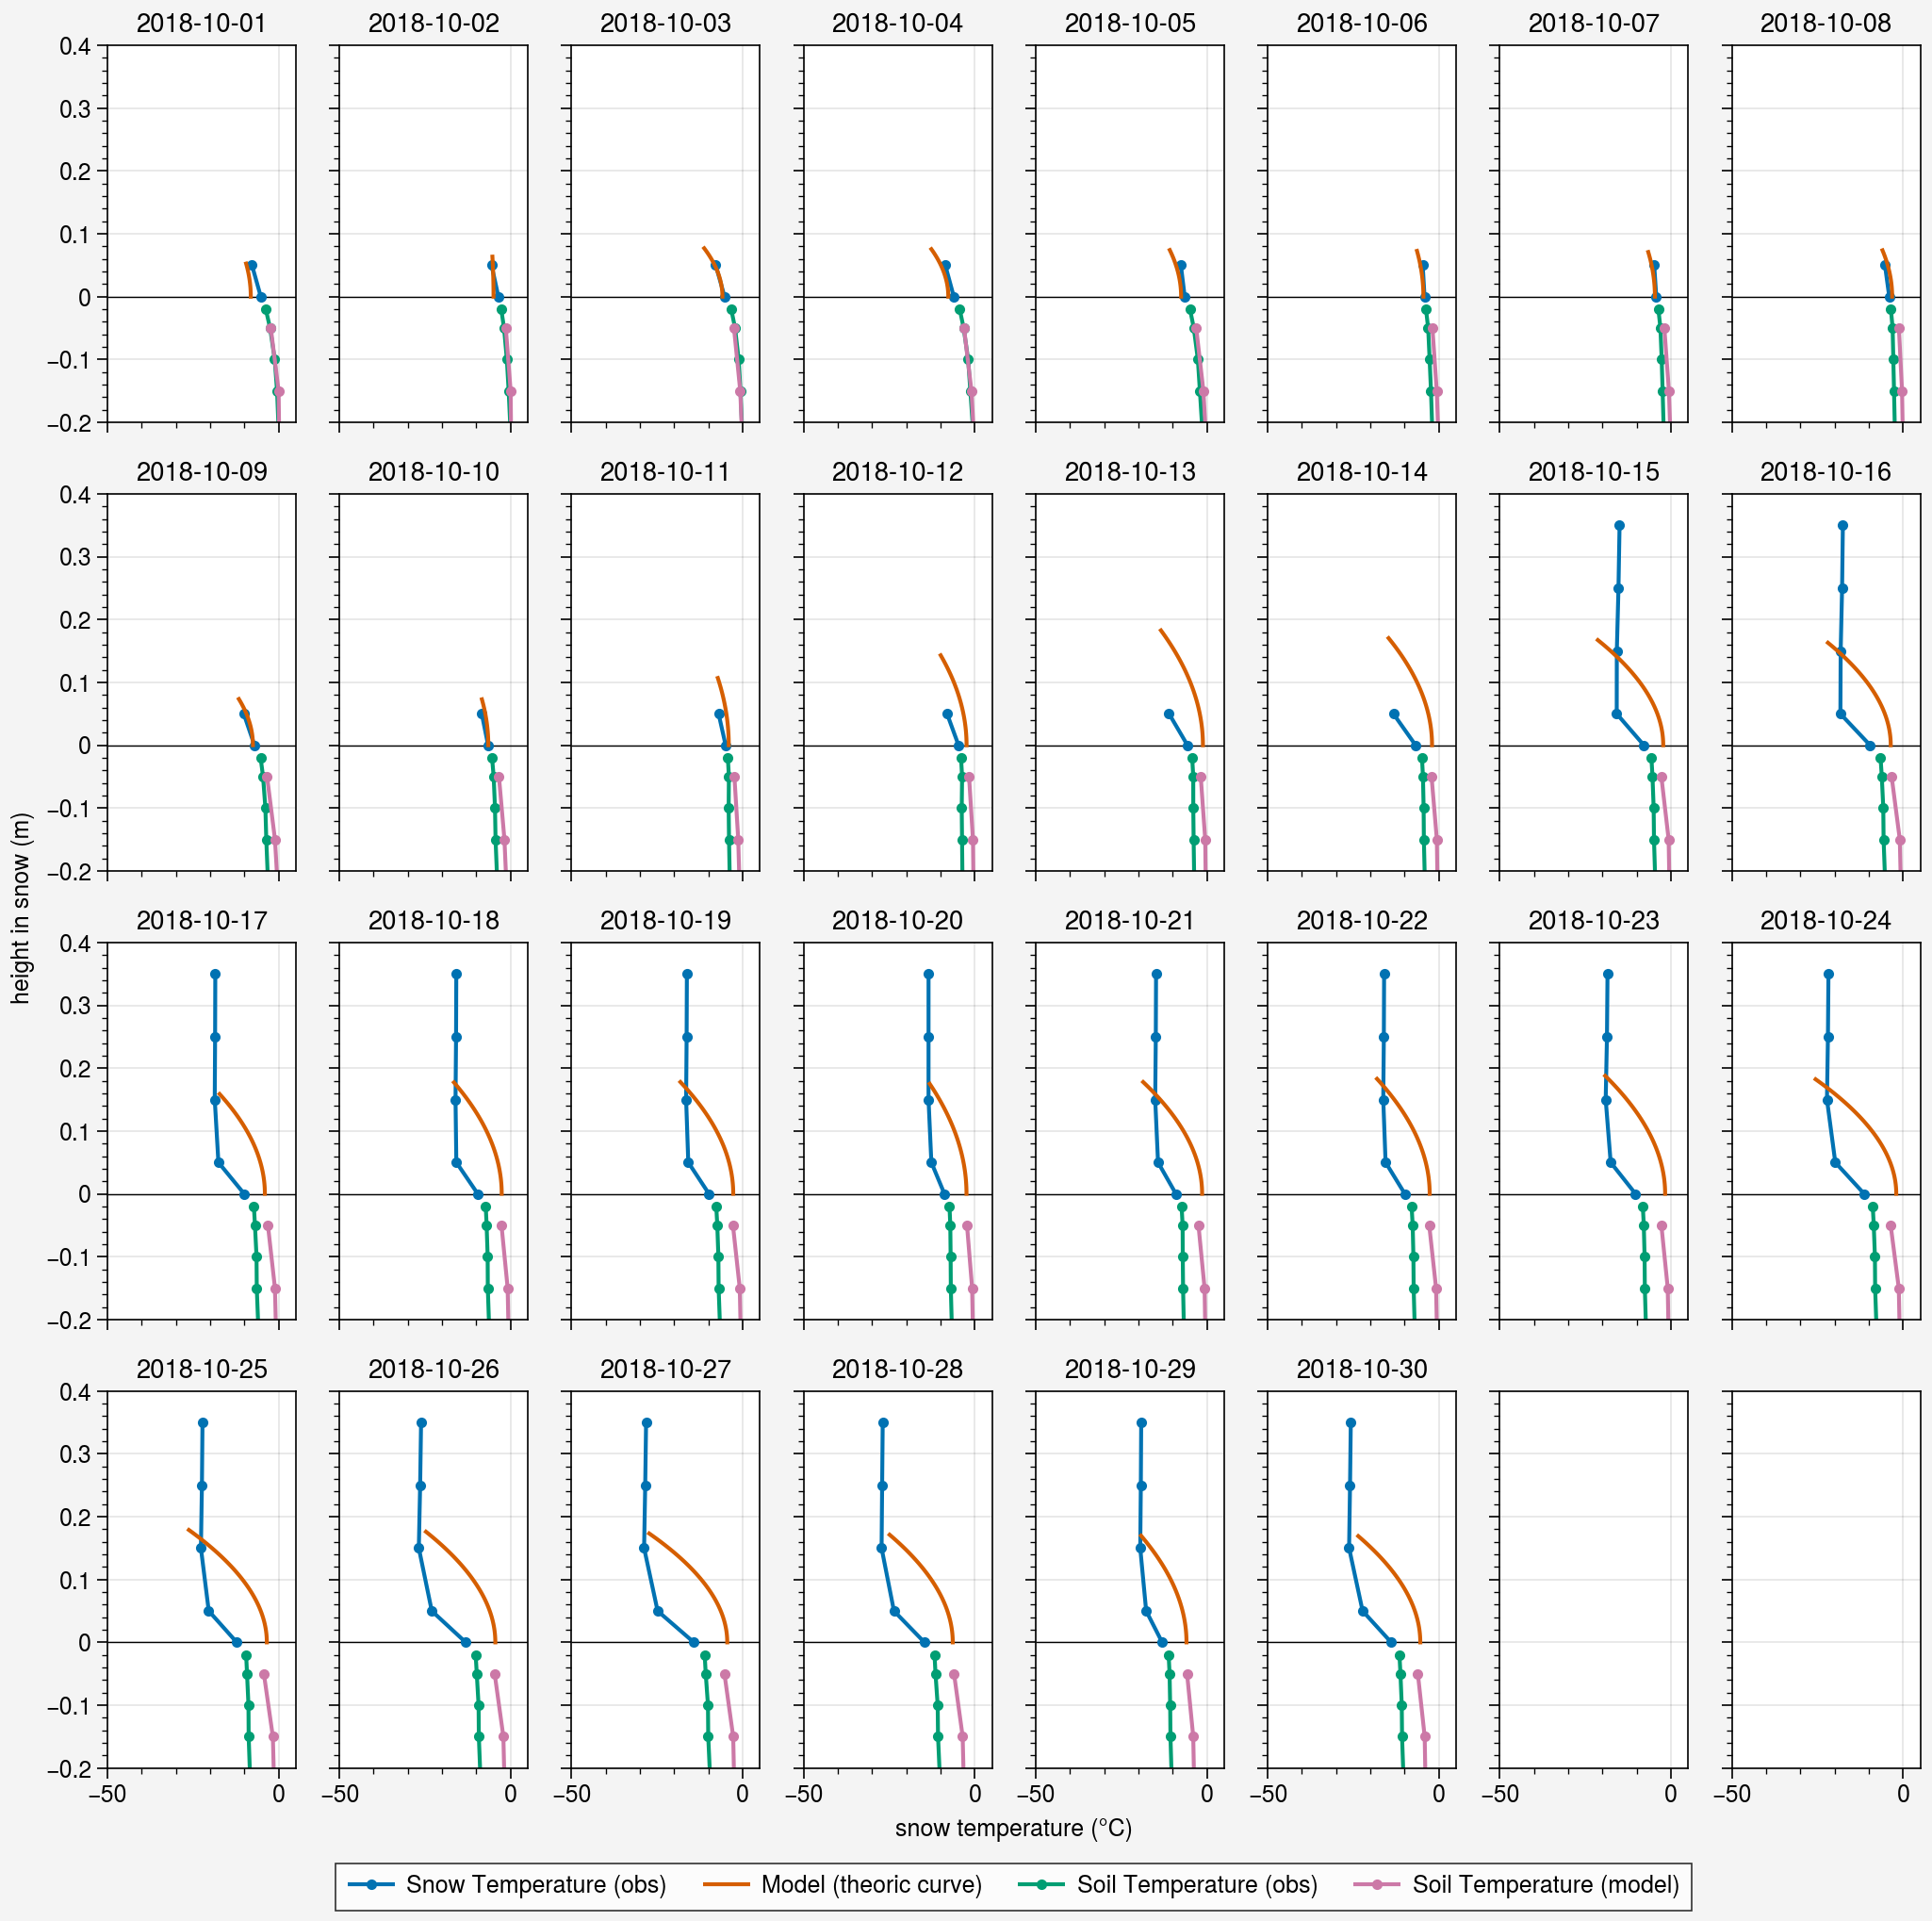

In [207]:
%matplotlib inline
import math
data_range = pd.date_range('2018-10-01', '2018-10-30')
# data_range = pd.date_range('2017-02-01', '2017-02-16')
ncols = 8
fig, axs = pplt.subplots(refaspect=0.5, ncols=ncols, nrows=math.ceil(data_range.size/ncols), refwidth=1)

for i, date in enumerate(data_range):

    z = np.linspace(0, ds_d_list[1].sel(time=date).snd.squeeze())
    c = (ds_d_list[1].sel(time=date).ts).values
    b = ((-3/ds_d_list[1].sel(time=date).snd)*(c-ds_d_list[1].sel(time=date).tsn.values)).values
    a = (-b/ds_d_list[1].sel(time=date).snd).values
    tsn_theoric = T(z, a, b, c)
    
    axs[i].plot(ds_d_obs.tsnl.sel(time=date).dropna(dim='sheight'), ds_d_obs.tsnl.sel(time=date).dropna(dim='sheight').sheight, 
                label='Snow Temperature (obs)', marker='.')
    # axs[i].plot(ds_d_obs.ts.sel(time=date), ds_d_obs.snd_auto.sel(time=date), label='Surace Temperature (obs)', marker='.')

    axs[i].plot(tsn_theoric.squeeze()-273.15, z[::-1], label='Model (theoric curve)')
    
    
    # axs[0].plot(ds_d_obs.tsl.sel(time=date, sdepth=0.02), -0.02, label='Soil', marker='.')
    axs[i].plot(ds_d_obs.tsl.sel(time=date), -ds_d_obs.sdepth, label='Soil Temperature (obs)', marker='.')
    axs[i].plot(ds_d_list[1].tsl.sel(time=date)-273.15, -ds_d_list[0].layer, label='Soil Temperature (model)', marker='.')
    axs[i].format(xlim=(-50, 5), ylim=(-0.2, 0.4), title=str(date)[:10])
    axs[i].hlines(0, -50, 5, color='k', lw=0.5)
    if i == 0: fig.legend(loc='b', ncols=4)


    
# axs[0].format(xlabel='Snow Temperature (°C)', ylabel='Snow Depth (cm)', title=date,
#              lltitle='tsn_obs: {:.2f}'.format(tsn_obs)+' °C\ntsn_th: {:.2f}'.format(tsn_th.item(0))+' °C')

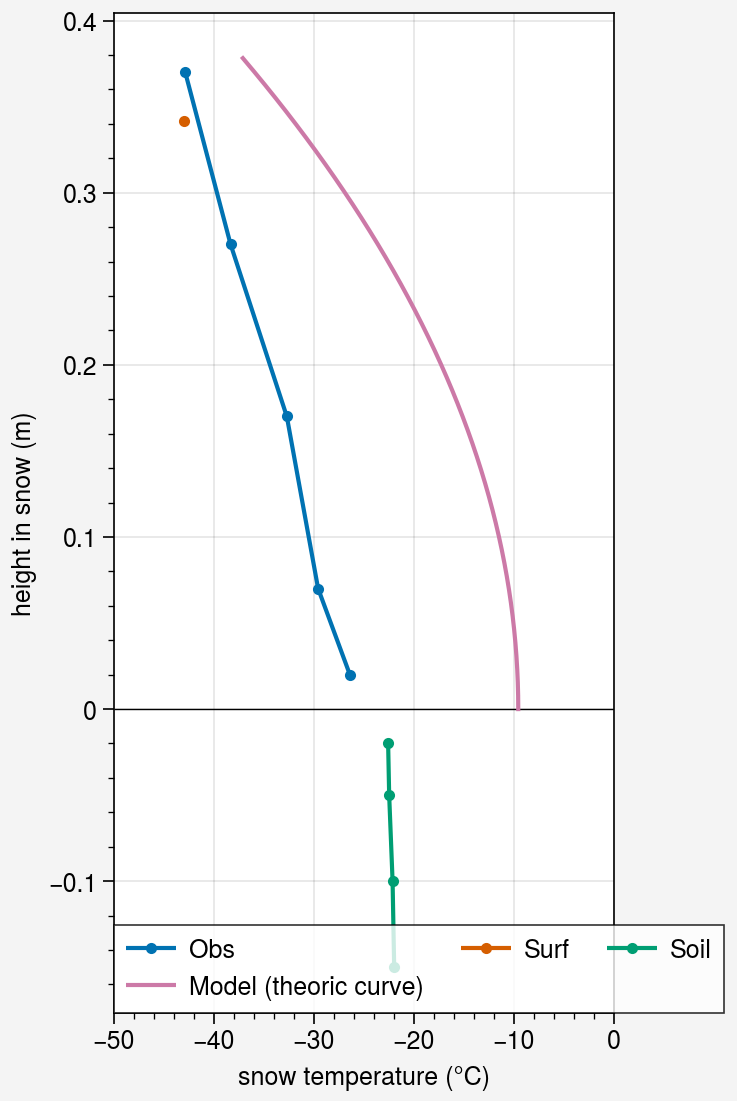

In [138]:
%matplotlib inline
fig, axs = pplt.subplots(refaspect=0.5)

date = '2016-02-01'
axs[0].plot(ds_d_obs.tsnl.sel(time=date).dropna(dim='sheight'), ds_d_obs.tsnl.sel(time=date).dropna(dim='sheight').sheight, label='Obs', marker='.')
axs[0].plot(ds_d_obs.ts.sel(time=date), ds_d_obs.snd_auto.sel(time=date), label='Surf', marker='.')
# axs[0].plot(ds_d_obs.tsl.sel(time=date, sdepth=0.02), -0.02, label='Soil', marker='.')
axs[0].plot(ds_d_obs.tsl.sel(time=date), -ds_d_obs.sdepth, label='Soil', marker='.')
axs[0].plot(tsn_theoric.squeeze()-273.15, z[::-1], label='Model (theoric curve)')
axs[0].legend()
axs[0].format(xlim=(-50, 0))
axs[0].hlines(0, -50, 0, color='k', lw=0.5)

# axs[0].format(xlabel='Snow Temperature (°C)', ylabel='Snow Depth (cm)', title=date,
#              lltitle='tsn_obs: {:.2f}'.format(tsn_obs)+' °C\ntsn_th: {:.2f}'.format(tsn_th.item(0))+' °C')

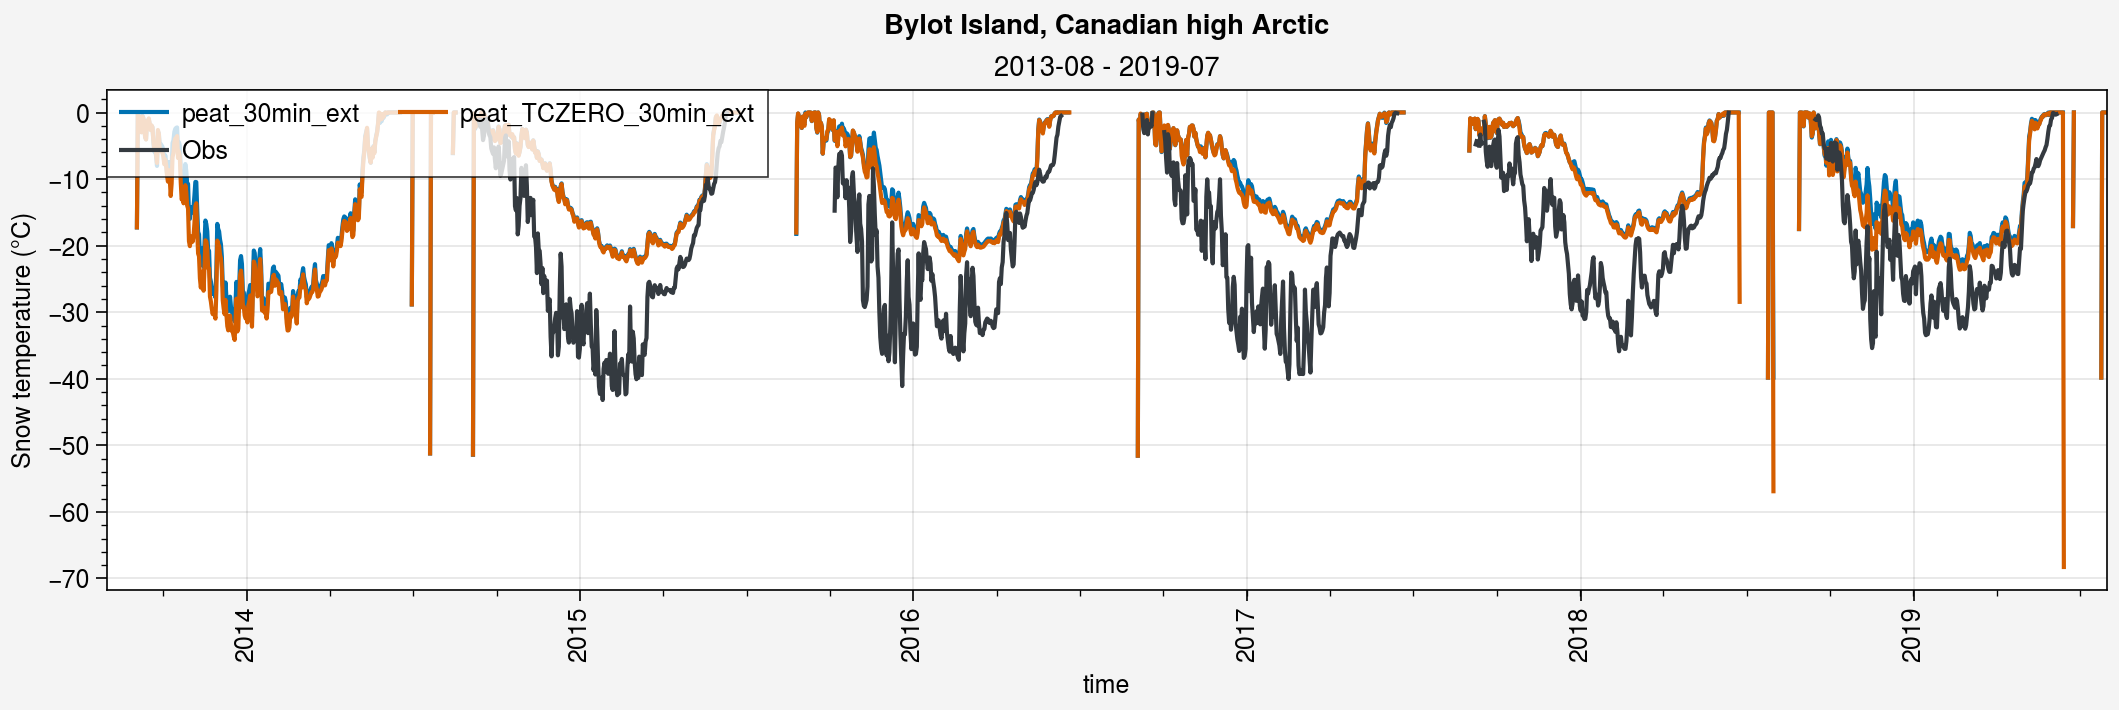

In [18]:
%matplotlib inline
gap = 6
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.tsn.sel(time=period).where(ds_d.tsn > 200)-273.15, label=label)
        
    # Obs
    axs[0].plot(ds_d_obs.tsnl.mean('sheight').sel(time=period), color=color_obs, label='Obs')
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Snow temperature (°C)')
    
    fig.suptitle(site_longname)


### Volumetric water content

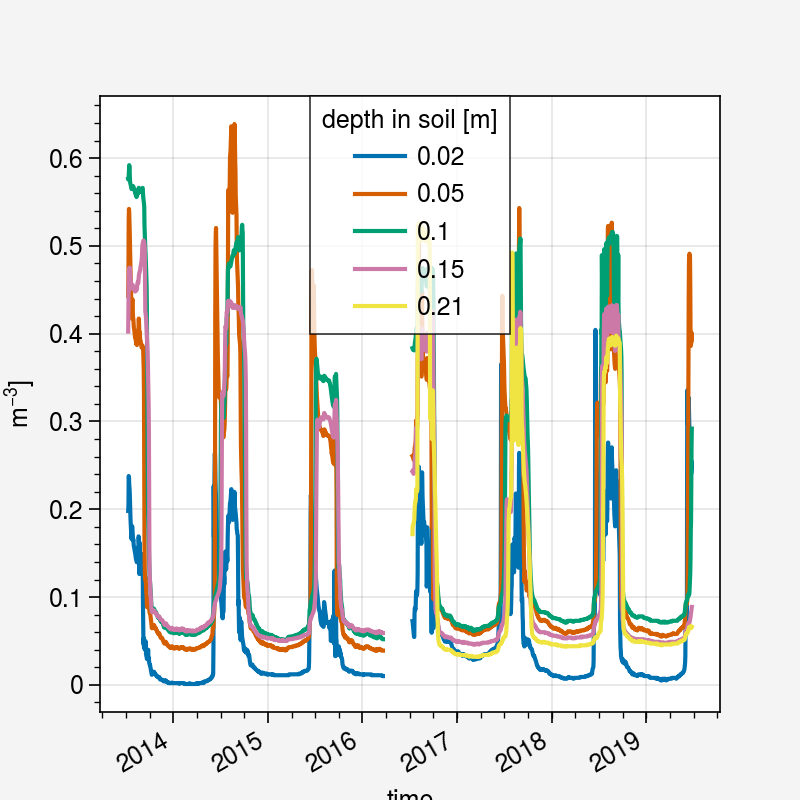

In [68]:
%matplotlib inline
ds_d_obs.mrsll.plot(hue='sdepth')

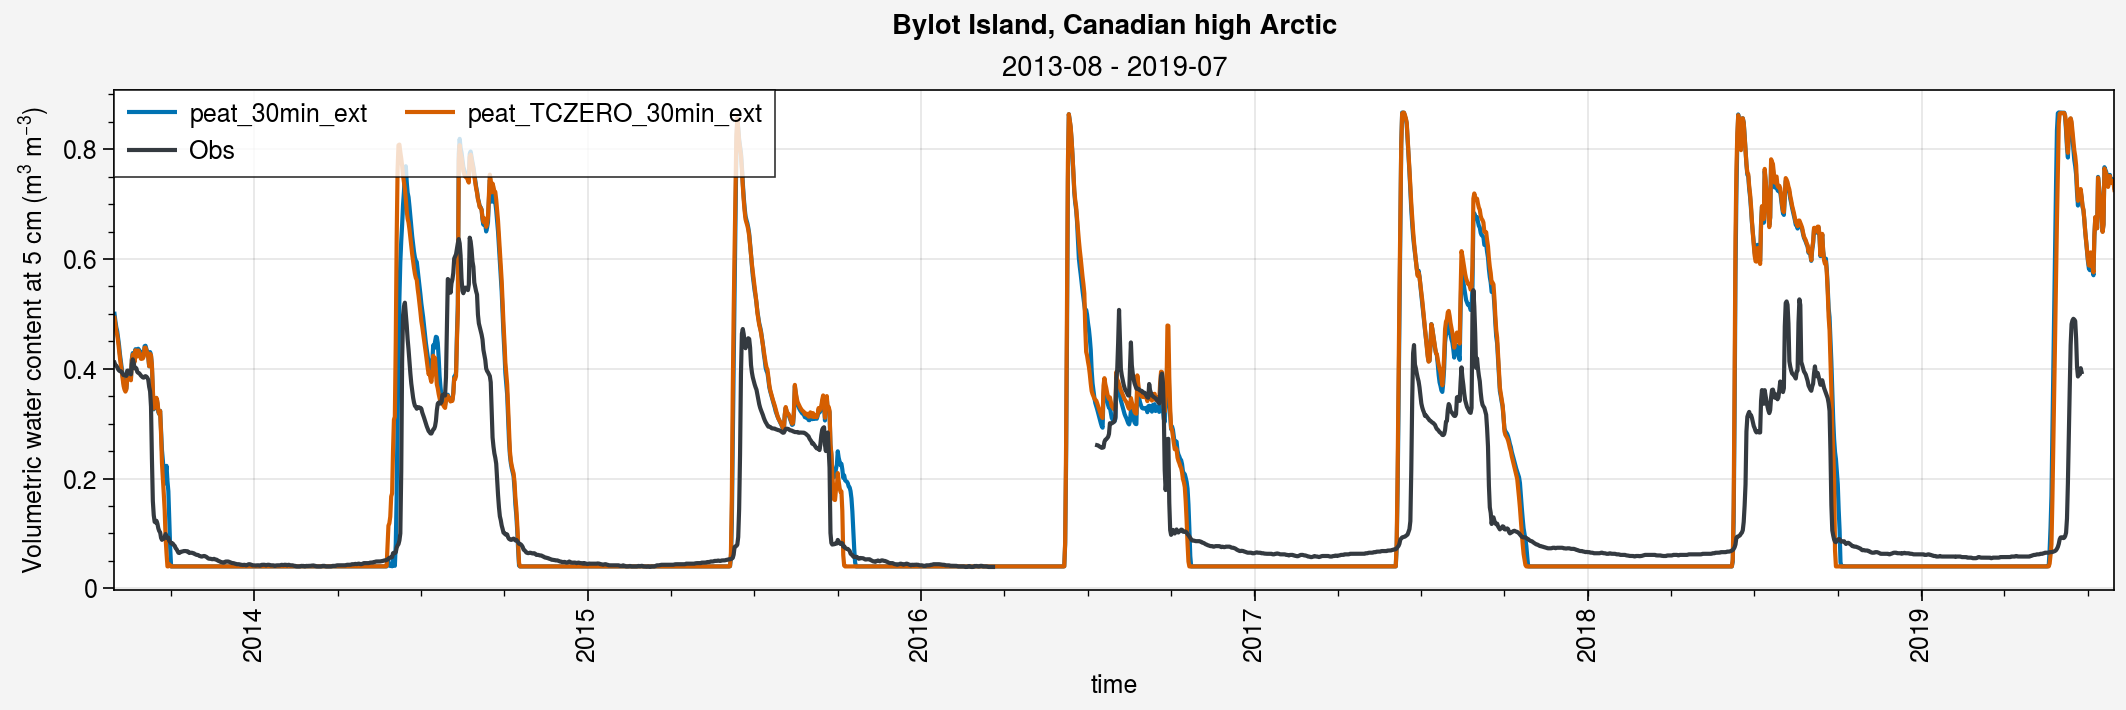

In [19]:
%matplotlib inline
gap = 6
color_obs = 'gray8'
sdepth = 0.05
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.mrsll.sel(time=period).sel(layer=sdepth)/100, label=label)
        
    # Obs
    axs[0].plot(ds_d_obs.mrsll.sel(time=period, sdepth=sdepth), color=color_obs, label='Obs')
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Volumetric water content at '+sdepth_label+' cm (m$^3$ m$^{-3}$)')
    
    fig.suptitle(site_longname)


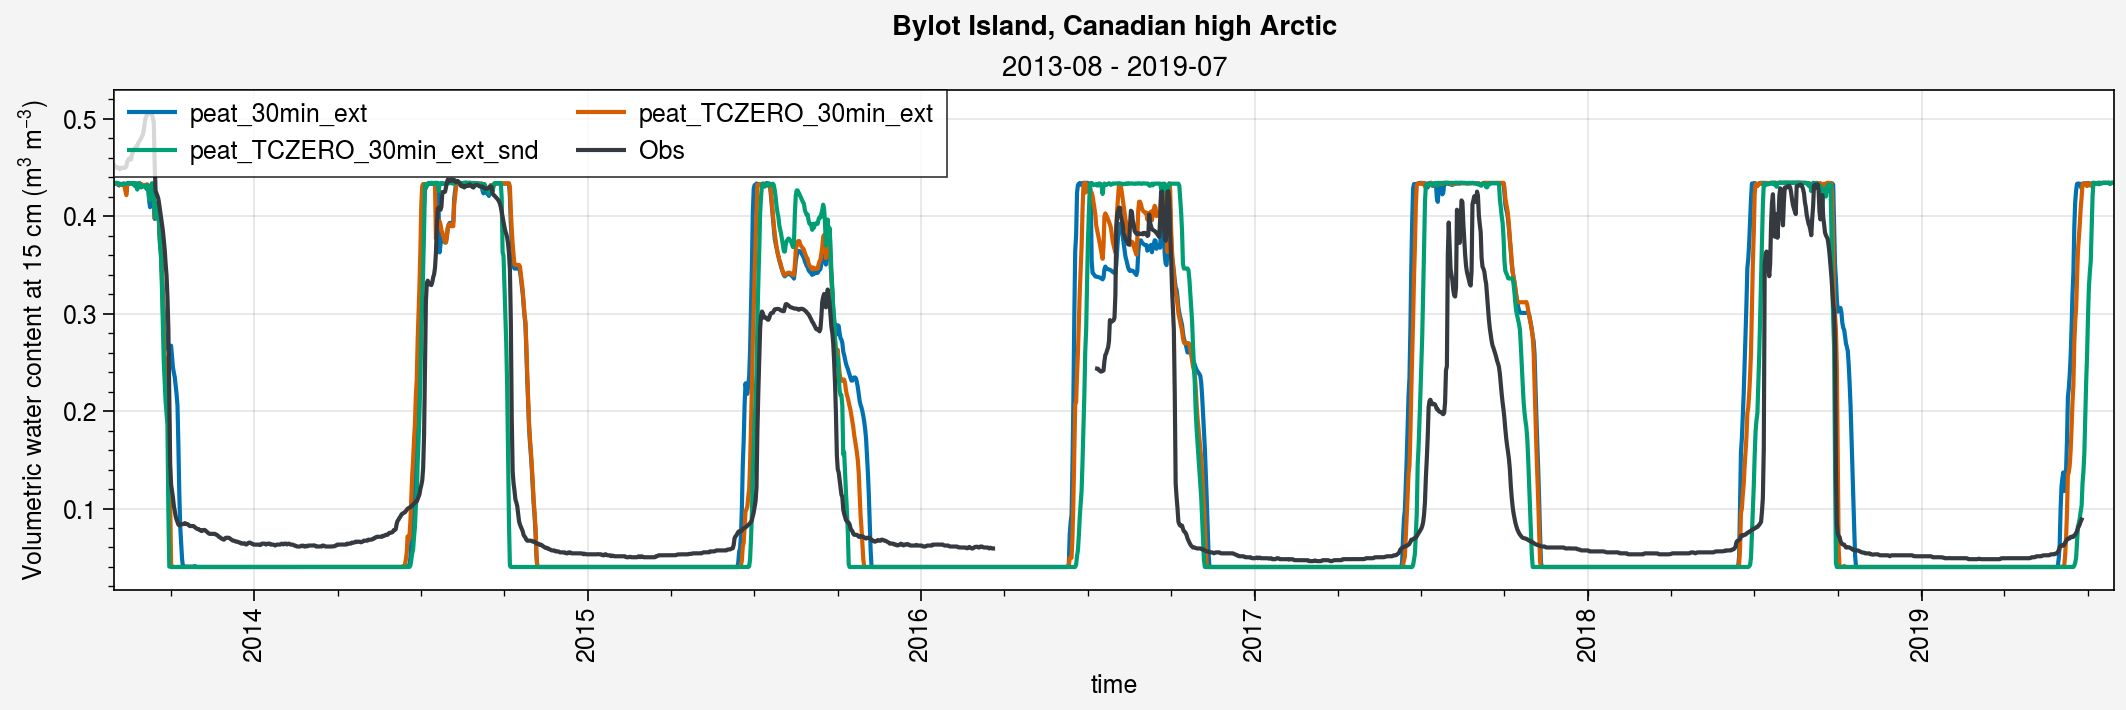

In [22]:
%matplotlib inline
gap = 6
color_obs = 'gray8'
sdepth = 0.15
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.mrsll.sel(time=period).sel(layer=sdepth, method='nearest')/100, label=label)
        
    # Obs
    axs[0].plot(ds_d_obs.mrsll.sel(time=period, sdepth=sdepth), color=color_obs, label='Obs')
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Volumetric water content at '+sdepth_label+' cm (m$^3$ m$^{-3}$)')
    
    fig.suptitle(site_longname)


## All 

In [21]:
ds_d_obs

<xarray.Dataset> Size: 435kB
Dimensions:         (time: 2176, sdepth: 5, sheight: 10)
Coordinates:
  * sdepth          (sdepth) float64 40B 0.02 0.05 0.1 0.15 0.21
  * sheight         (sheight) float64 80B 0.0 0.02 0.05 0.07 ... 0.27 0.35 0.37
  * time            (time) datetime64[ns] 17kB 2013-07-11 ... 2019-06-25
Data variables:
    snd_auto        (time) float64 17kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    albs            (time) float64 17kB 0.1815 0.1357 0.1493 ... 0.1625 0.1964
    flag_albs_ERA5  (time) float64 17kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ts              (time) float64 17kB 11.03 5.161 6.706 ... 5.245 4.045 4.336
    mrsll           (time, sdepth) float64 87kB 0.1981 0.4431 ... 0.08873 0.066
    tsl             (time, sdepth) float64 87kB 6.497 3.928 1.357 ... 0.79 -0.3
    tsnl            (time, sheight) float64 174kB nan nan nan ... nan nan nan
Attributes:
    reference:    Domine, F., Lackner, G., Sarrazin, D., Poirier, M., & Belke...
    description:  Converted to netCDF (SnowMIP kind of format) from original ...

Text(0.5, 0.98, 'Bylot Island, Canadian high Arctic (2017-09-01 - 2019-07-01)')

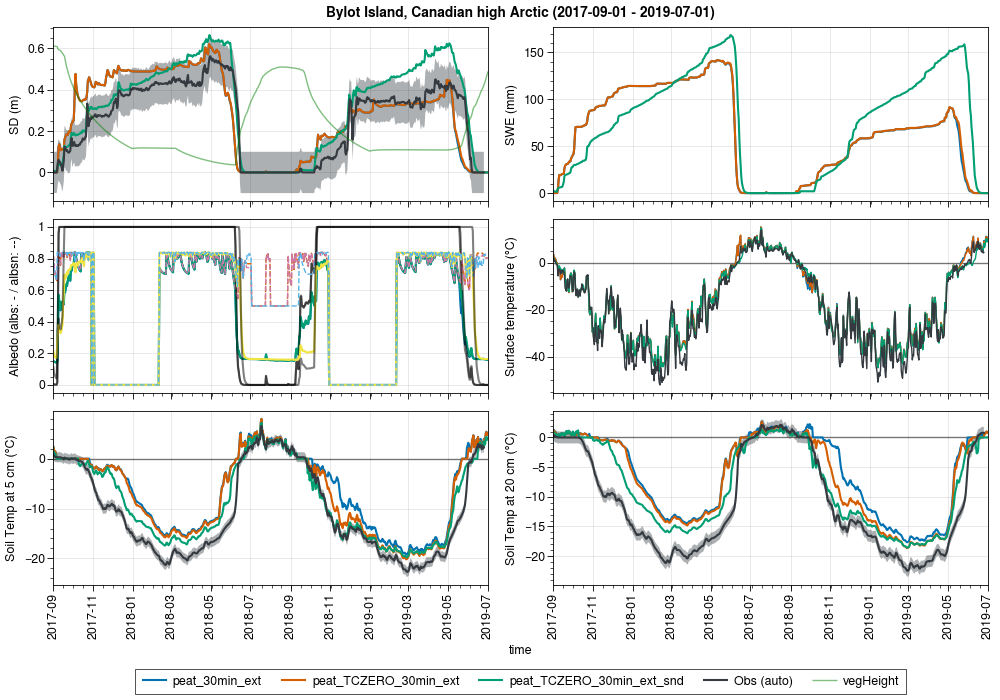

In [23]:
%matplotlib widget
color_obs = 'gray8'
period=slice('2017-09-01', '2019-07-01')

fig, axs = pplt.subplots(nrows=3, ncols=2, refaspect=3.5, sharey=0, figsize=(10,7))

##################
### Snow Depth ###
##################

# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.snd.sel(time=period), label=label)

# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
axs[0].plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs, label='Obs (auto)')

# Veg
axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', alpha=0.5, lw=1)

fig.legend(loc='b', ncols=5)
axs[0].format(ylabel='SD (m)')

##################
### SWE ###
##################
 # Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[1].plot(ds_d.snw.sel(time=period), label=label)

# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_eval_menard2019.snw_auto.sel(time=period).values+25, axis=0),
#     np.expand_dims(ds_d_eval_menard2019.snw_auto.sel(time=period).values-25, axis=0),), axis=0)
# axs[1].plot(ds_d_eval_menard2019.snw_auto.sel(time=period), shadedata=shadedata, color=color_obs)
# axs[1].plot(ds_d_eval_menard2019.snw_man.sel(time=period), marker='.', color=color_obs)
axs[1].format(ylabel='SWE (mm)')

##################
### Albedo ###
##################
# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[2].plot(ds_d.albs.sel(time=period), label=label+' (albs)')
    axs[2].plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', ls='--', lw=1)
    axs[2].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)

# Obs
# axs[2].plot(ds_d_eval_menard2019.albs.sel(time=period), marker='.', color=color_obs)
axs[2].format(ylabel='Albedo (albs: - / albsn: --)')

##################
### TS ###
##################
# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[3].plot(ds_d.ts.sel(time=period)-273.15, label=label, lw=1)

# Obs
axs[3].plot(ds_d_obs.ts.sel(time=period), color=color_obs, lw=1)
axs[3].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
axs[3].format(ylabel='Surface temperature (°C)')

##################
### T soil ###
##################
# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[4].plot(ds_d.tsl.sel(time=period, layer=0.05)-273.15, label=label)
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)-1, axis=0),), axis=0)
axs[4].plot(ds_d_obs.tsl.sel(time=period, sdepth=0.05), shadedata=shadedata, color=color_obs)

axs[4].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
axs[4].format(ylabel='Soil Temp at 5 cm (°C)')

# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[5].plot(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest')-273.15, label=label)

# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)-1, axis=0),), axis=0)
axs[5].plot(ds_d_obs.tsl.sel(time=period, sdepth=0.15), shadedata=shadedata, color=color_obs)

axs[5].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
axs[5].format(ylabel='Soil Temp at 20 cm (°C)')


fig.suptitle(site_longname + ' ('+period.start+' - '+period.stop+')')
# fig.save('img/run_30min_ext_TCZERO_snd_1996_1997.jpg')

Text(0.5, 0.98, 'Bylot Island, Canadian high Arctic (2017-09-01 - 2019-07-01)')

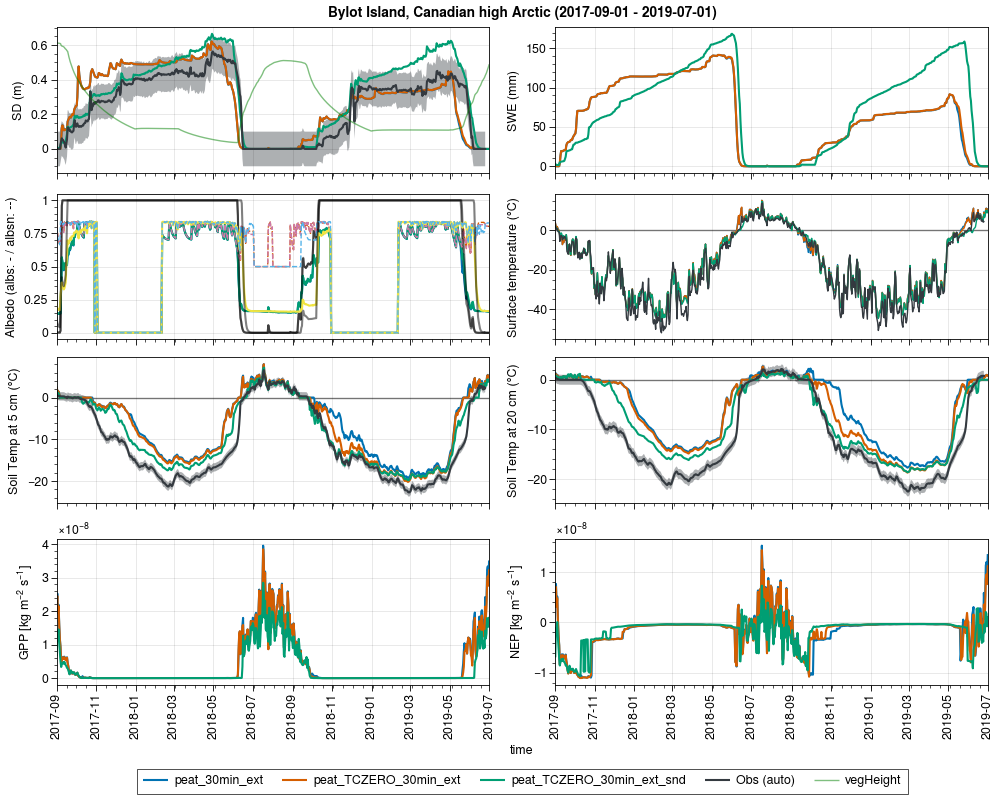

In [41]:
%matplotlib widget
color_obs = 'gray8'
period=slice('2017-09-01', '2019-07-01')

fig, axs = pplt.subplots(nrows=4, ncols=2, refaspect=3.5, sharey=0, figsize=(10,8))

##################
### Snow Depth ###
##################

# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.snd.sel(time=period), label=label)

# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
axs[0].plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs, label='Obs (auto)')

# Veg
axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', alpha=0.5, lw=1)

fig.legend(loc='b', ncols=5)
axs[0].format(ylabel='SD (m)')

##################
### SWE ###
##################
 # Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[1].plot(ds_d.snw.sel(time=period), label=label)

# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_eval_menard2019.snw_auto.sel(time=period).values+25, axis=0),
#     np.expand_dims(ds_d_eval_menard2019.snw_auto.sel(time=period).values-25, axis=0),), axis=0)
# axs[1].plot(ds_d_eval_menard2019.snw_auto.sel(time=period), shadedata=shadedata, color=color_obs)
# axs[1].plot(ds_d_eval_menard2019.snw_man.sel(time=period), marker='.', color=color_obs)
axs[1].format(ylabel='SWE (mm)')

##################
### Albedo ###
##################
# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[2].plot(ds_d.albs.sel(time=period), label=label+' (albs)')
    axs[2].plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', ls='--', lw=1)
    axs[2].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)

# Obs
# axs[2].plot(ds_d_eval_menard2019.albs.sel(time=period), marker='.', color=color_obs)
axs[2].format(ylabel='Albedo (albs: - / albsn: --)')

##################
### TS ###
##################
# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[3].plot(ds_d.ts.sel(time=period)-273.15, label=label, lw=1)

# Obs
axs[3].plot(ds_d_obs.ts.sel(time=period), color=color_obs, lw=1)
axs[3].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
axs[3].format(ylabel='Surface temperature (°C)')

##################
### T soil ###
##################
# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[4].plot(ds_d.tsl.sel(time=period, layer=0.05)-273.15, label=label)
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)-1, axis=0),), axis=0)
axs[4].plot(ds_d_obs.tsl.sel(time=period, sdepth=0.05), shadedata=shadedata, color=color_obs)

axs[4].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
axs[4].format(ylabel='Soil Temp at 5 cm (°C)')

# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[5].plot(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest')-273.15, label=label)

# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)-1, axis=0),), axis=0)
axs[5].plot(ds_d_obs.tsl.sel(time=period, sdepth=0.15), shadedata=shadedata, color=color_obs)

axs[5].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
axs[5].format(ylabel='Soil Temp at 20 cm (°C)')


# Carbon

# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[6].plot(ds_d.gpp.sel(time=period), label=label)
axs[6].format(ylabel='GPP [kg m$^{-2}$ s$^{-1}$]')

for ds_d, label in zip(ds_d_list, labels):
    axs[7].plot(ds_d.nep.sel(time=period), label=label)
axs[7].format(ylabel='NEP [kg m$^{-2}$ s$^{-1}$]')


fig.suptitle(site_longname + ' ('+period.start+' - '+period.stop+')')
# fig.save('img/run_30min_ext_TCZERO_snd_1996_1997.jpg')

In [42]:
ds_d_list[0].nep.sel(time=period).mean()

<xarray.DataArray 'nep' ()> Size: 8B
array(-1.6499287e-09)

In [43]:
ds_d_list[1].nep.sel(time=period).mean()

<xarray.DataArray 'nep' ()> Size: 8B
array(-1.58898558e-09)

In [44]:
ds_d_list[2].nep.sel(time=period).mean()

<xarray.DataArray 'nep' ()> Size: 8B
array(-1.62504558e-09)

In [35]:
ds_d_list[0]

<xarray.Dataset> Size: 2MB
Dimensions:     (time: 2556, layer: 20)
Coordinates:
  * time        (time) datetime64[ns] 20kB 2013-01-01 2013-01-02 ... 2019-12-31
  * layer       (layer) float64 160B 0.05 0.15 0.25 0.35 ... 8.9 18.9 41.4 58.9
Data variables: (12/50)
    longitude   float64 8B -80.0
    latitude    float64 8B 73.15
    actlyr      (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    albs        (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    albsir      (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    albsn       (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...          ...
    tsl         (time, layer) float64 409kB 259.3 261.1 261.4 ... 266.8 266.8
    tsn         (time) float64 20kB 255.3 253.9 254.3 ... 255.6 255.4 256.7
    vegHeight   (time) float64 20kB 0.1411 0.1408 0.1405 ... 0.144 0.1421 0.1401
    wsnw        (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wtd         (time) float64 20kB 9.999e+03 9.999e+03 ... 9.999e+03 9.999e+03
    zpond       (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:        CLASSIC output file
    timestamp:    20240226 1055
    Conventions:  COARDS
    node_offset:  1
    Comment:       run_peat_30min_ext (spinfast=1)

In [34]:
ds_d_list[0].nep

<xarray.DataArray 'nep' (time: 2556)> Size: 20kB
array([-4.81318725e-10, -4.61753297e-10, -4.55159501e-10, ...,
       -4.86585904e-10, -4.80048620e-10, -4.90232049e-10])
Coordinates:
  * time     (time) datetime64[ns] 20kB 2013-01-01 2013-01-02 ... 2019-12-31
Attributes:
    long_name:   Natural flux of CO2 (expressed as a mass flux of carbon) fro...
    units:       kg m$^{-2}$ s$^{-1}$
    nameInCode:  nep_d_g

Text(0.5, 0.98, 'Bylot Island, Canadian high Arctic (2013-09-01 - 2019-07-01)')

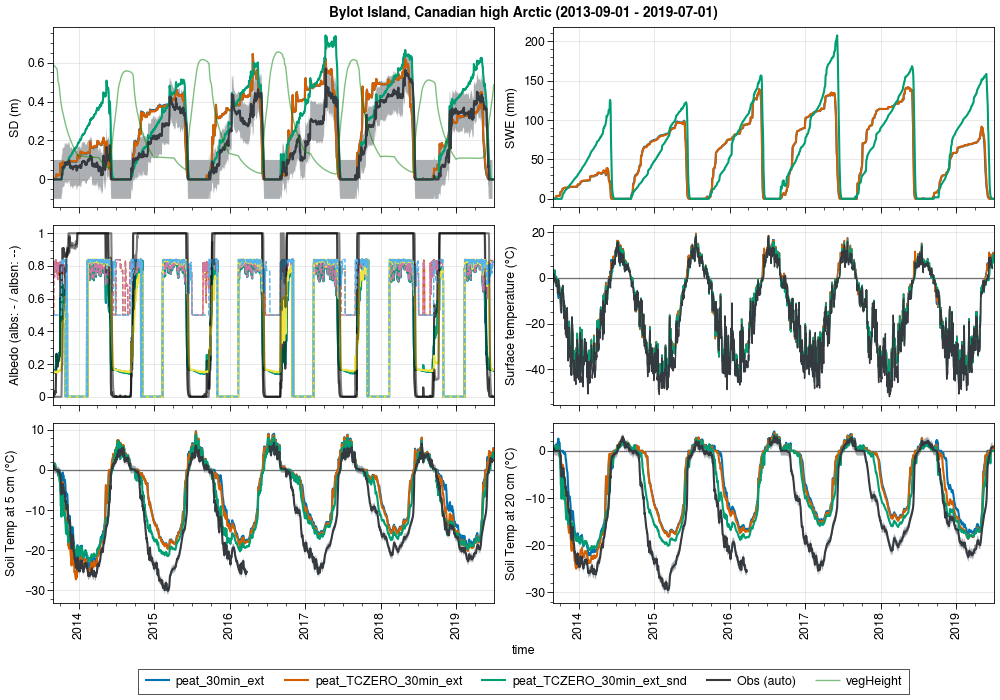

In [25]:
%matplotlib widget
color_obs = 'gray8'
period=slice('2013-09-01', '2019-07-01')

fig, axs = pplt.subplots(nrows=3, ncols=2, refaspect=3.5, sharey=0, figsize=(10,7))

##################
### Snow Depth ###
##################

# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.snd.sel(time=period), label=label)

# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
axs[0].plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs, label='Obs (auto)')

# Veg
axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', alpha=0.5, lw=1)

fig.legend(loc='b', ncols=5)
axs[0].format(ylabel='SD (m)')

##################
### SWE ###
##################
 # Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[1].plot(ds_d.snw.sel(time=period), label=label)

# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_eval_menard2019.snw_auto.sel(time=period).values+25, axis=0),
#     np.expand_dims(ds_d_eval_menard2019.snw_auto.sel(time=period).values-25, axis=0),), axis=0)
# axs[1].plot(ds_d_eval_menard2019.snw_auto.sel(time=period), shadedata=shadedata, color=color_obs)
# axs[1].plot(ds_d_eval_menard2019.snw_man.sel(time=period), marker='.', color=color_obs)
axs[1].format(ylabel='SWE (mm)')

##################
### Albedo ###
##################
# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[2].plot(ds_d.albs.sel(time=period), label=label+' (albs)')
    axs[2].plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', ls='--', lw=1)
    axs[2].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)

# Obs
# axs[2].plot(ds_d_eval_menard2019.albs.sel(time=period), marker='.', color=color_obs)
axs[2].format(ylabel='Albedo (albs: - / albsn: --)')

##################
### TS ###
##################
# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[3].plot(ds_d.ts.sel(time=period)-273.15, label=label, lw=1)

# Obs
axs[3].plot(ds_d_obs.ts.sel(time=period), color=color_obs, lw=1)
axs[3].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
axs[3].format(ylabel='Surface temperature (°C)')

##################
### T soil ###
##################
# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[4].plot(ds_d.tsl.sel(time=period, layer=0.05)-273.15, label=label)
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)-1, axis=0),), axis=0)
axs[4].plot(ds_d_obs.tsl.sel(time=period, sdepth=0.05), shadedata=shadedata, color=color_obs)

axs[4].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
axs[4].format(ylabel='Soil Temp at 5 cm (°C)')

# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[5].plot(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest')-273.15, label=label)

# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)-1, axis=0),), axis=0)
axs[5].plot(ds_d_obs.tsl.sel(time=period, sdepth=0.15), shadedata=shadedata, color=color_obs)

axs[5].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
axs[5].format(ylabel='Soil Temp at 20 cm (°C)')


fig.suptitle(site_longname + ' ('+period.start+' - '+period.stop+')')
# fig.save('img/run_30min_ext_TCZERO_snd_1996_1997.jpg')

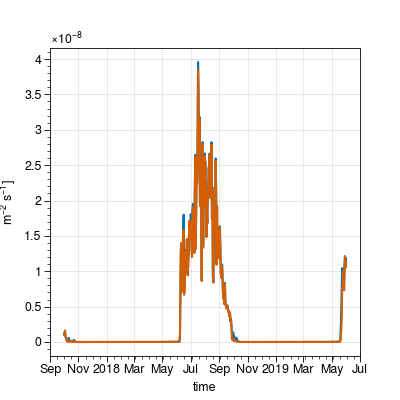

In [34]:
%matplotlib widget
period=slice('2017-10-01', '2019-06-01')

ds_d_list[0].gpp.sel(time=period).plot()
ds_d_list[1].gpp.sel(time=period).plot()

In [39]:
ds_hh_list[0].gflx

<xarray.DataArray 'gflx' (time: 35040)> Size: 280kB
array([-11.96314257, -11.66188451, -11.16265734, ...,          nan,
                nan,          nan])
Coordinates:
  * time     (time) datetime64[ns] 280kB 2013-01-01 ... 2014-12-31T23:30:00
Attributes:
    long_name:   Heat conduction between soil layers
    units:       W m$^{-2}$
    nameInCode:  gflx_hh

In [42]:
ds_hh_list[0]

<xarray.Dataset> Size: 36MB
Dimensions:     (time: 35040, layer: 20)
Coordinates:
  * time        (time) datetime64[ns] 280kB 2013-01-01 ... 2014-12-31T23:30:00
  * layer       (layer) int16 40B 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20
Data variables: (12/52)
    longitude   float64 8B -80.0
    latitude    float64 8B 73.15
    albs        (time) float64 280kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cdh         (time) float64 280kB 0.005613 0.003501 ... 0.00393 0.003694
    cdm         (time) float64 280kB 0.005355 0.003653 ... 0.004011 0.003815
    evspsblsoi  (time) float64 280kB 2.6e-06 1.166e-07 ... 1.713e-07 1.229e-07
    ...          ...
    tsgs        (time) float64 280kB 248.2 235.2 235.2 ... 235.3 235.3 235.3
    tsl         (time, layer) float64 6MB 259.6 261.1 261.4 ... 266.8 266.8
    tsn         (time) float64 280kB -16.68 -16.78 -16.87 ... -17.02 -17.03
    uvas        (time) float64 280kB 0.134 0.105 0.076 ... 0.117 0.064 0.0465
    wsnw        (time) float64 280kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    zpond       (time) float64 280kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:        CLASSIC output file
    timestamp:    20240226 1055
    Conventions:  COARDS
    node_offset:  1
    Comment:       run_peat_30min_ext (spinfast=1)

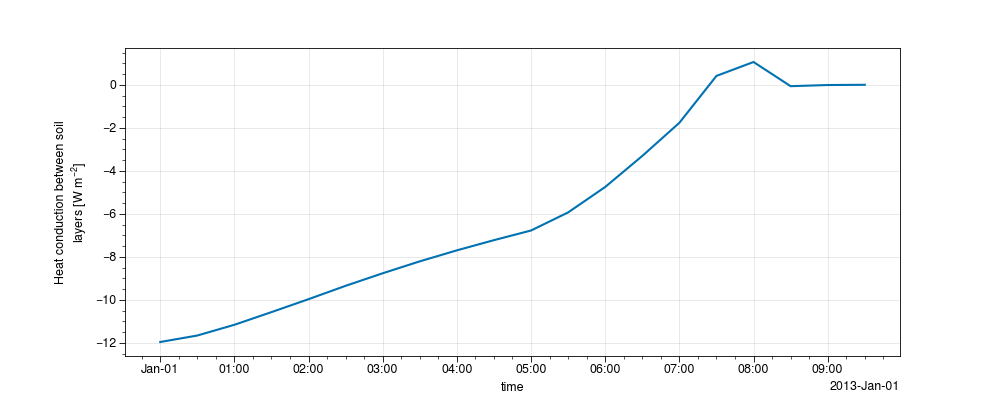

In [41]:
%matplotlib widget
# period=slice('2017-10-01', '2019-06-01')
plt.figure(figsize=(10, 4))
ds_hh_list[0].gflx.plot()

In [36]:
ds_hh_list[0]

<xarray.Dataset> Size: 36MB
Dimensions:     (time: 35040, layer: 20)
Coordinates:
  * time        (time) datetime64[ns] 280kB 2013-01-01 ... 2014-12-31T23:30:00
  * layer       (layer) int16 40B 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20
Data variables: (12/52)
    longitude   float64 8B -80.0
    latitude    float64 8B 73.15
    albs        (time) float64 280kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cdh         (time) float64 280kB 0.005613 0.003501 ... 0.00393 0.003694
    cdm         (time) float64 280kB 0.005355 0.003653 ... 0.004011 0.003815
    evspsblsoi  (time) float64 280kB 2.6e-06 1.166e-07 ... 1.713e-07 1.229e-07
    ...          ...
    tsgs        (time) float64 280kB 248.2 235.2 235.2 ... 235.3 235.3 235.3
    tsl         (time, layer) float64 6MB 259.6 261.1 261.4 ... 266.8 266.8
    tsn         (time) float64 280kB -16.68 -16.78 -16.87 ... -17.02 -17.03
    uvas        (time) float64 280kB 0.134 0.105 0.076 ... 0.117 0.064 0.0465
    wsnw        (time) float64 280kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    zpond       (time) float64 280kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:        CLASSIC output file
    timestamp:    20240226 1055
    Conventions:  COARDS
    node_offset:  1
    Comment:       run_peat_30min_ext (spinfast=1)